# XGBoost Train
- ÌîºÏ≥êÏóîÏßÄÎãàÏñ¥ÎßÅ v00
- Ïª¨Îüº 350Í∞ú -> 217Í∞ú

-ÏõêÎûò Ïä§ÏΩîÏñ¥ 267ÌîºÏ≥êÏùºÎïå Ïä§ÏΩîÏñ¥  
Train ÏÑ±Îä•: (Í≥ºÏ†ÅÌï©)
  Ï†ïÌôïÎèÑ: 0.9560
  F1 (Macro): 0.9027
  F1 (Weighted): 0.9584
  ROC AUC: 0.9986

Test ÏÑ±Îä•:
  Ï†ïÌôïÎèÑ: 0.7753
  F1 (Macro): 0.3932
  F1 (Weighted): 0.7606
  ROC AUC: 0.6121

In [51]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
from datetime import datetime

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî
import optuna
from optuna.samplers import TPESampler


In [53]:
# =============================================================================
# ÏÖÄ 2: Í≤ΩÎ°ú ÏÑ§Ï†ï Î∞è ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
# =============================================================================
# Í≤ΩÎ°ú ÏÑ§Ï†ï
data_dir = '/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B'
output_dir = '/workspace/AIÎ™®Îç∏/projects/coin/models'

# ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
os.makedirs(output_dir, exist_ok=True)

# ÏÑ§Ï†ïÍ∞í
N_FOLDS = 5     
N_TRIALS = 15   # n Î≤à ÏãúÎèÑ
RANDOM_STATE = 42

# GPU ÏµúÏ†ÅÌôî ÏÑ§Ï†ï
USE_GPU = True
GPU_DEVICE = 'cuda:0'
GPU_BATCH_SIZE = 10000
PARALLEL_JOBS = 1      # GPU ÏÇ¨Ïö©ÏãúÏóêÎäî 1 ÎòêÎäî 2Í∞Ä ÏµúÏ†Å

# Î©îÎ™®Î¶¨ Î™®ÎãàÌÑ∞ÎßÅ ÌôúÏÑ±Ìôî
MEMORY_MONITORING = True

print(f"Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨: {data_dir}")
print(f"Ï∂úÎ†• ÎîîÎ†âÌÜ†Î¶¨: {output_dir}")
print(f"K-Fold: {N_FOLDS}Ìè¥Îìú, Optuna ÏãúÎèÑ: {N_TRIALS}Ìöå (Î©îÎ™®Î¶¨ ÏïàÏ†Ñ Î™®Îìú)")
print(f"GPU ÏÇ¨Ïö©: {USE_GPU}")

# ÏãúÏä§ÌÖú Î©îÎ™®Î¶¨ ÌôïÏù∏
import psutil
total_ram = psutil.virtual_memory().total / (1024**3)
available_ram = psutil.virtual_memory().available / (1024**3)
print(f"ÏãúÏä§ÌÖú RAM: {total_ram:.1f}GB (ÏÇ¨Ïö©Í∞ÄÎä•: {available_ram:.1f}GB)")

Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨: /workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B
Ï∂úÎ†• ÎîîÎ†âÌÜ†Î¶¨: /workspace/AIÎ™®Îç∏/projects/coin/models
K-Fold: 5Ìè¥Îìú, Optuna ÏãúÎèÑ: 15Ìöå (Î©îÎ™®Î¶¨ ÏïàÏ†Ñ Î™®Îìú)
GPU ÏÇ¨Ïö©: True
ÏãúÏä§ÌÖú RAM: 47.0GB (ÏÇ¨Ïö©Í∞ÄÎä•: 37.7GB)


# Ï£ºÏùò! Data load
- Í∏∞Ï°¥Ïóê ÎßåÎì† Î≥ëÌï©Îêú ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ /workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B
- Ïó¨Í∏∞ÏÑúÏùò ÎùºÎ≤®ÏùÄ 'Optimized_Label'ÏûÑ Ïù¥Í±∏ -> Future_LabelÎ°ú Î≥ÄÌôòÌï® Îî∞ÎùºÏÑú Future_LabelÏù¥ ÏßÑÏßúÎùºÎ≤®

In [54]:
# =============================================================================
# ÏÖÄ 3: Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
# =============================================================================

def load_and_prepare_data(data_dir):
    """
    training_features.txtÎ•º ÏùΩÏñ¥ÏÑú Í∏∞Î≥∏ ÌîºÏ≤òÎ•º Î°úÎìúÌïòÍ≥†,
    Ï∂îÍ∞Ä Ï†úÏô∏ Ìï≠Î™©ÏùÑ Ï†ÅÏö©ÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
    """
    print("Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨ ÏãúÏûë...")
    
    # 1. training_features.txt ÌååÏùº ÏùΩÍ∏∞
    feature_file = os.path.join(data_dir, 'training_features.txt')
    
    if os.path.exists(feature_file):
        with open(feature_file, 'r') as f:
            base_features = [line.strip() for line in f.readlines() if line.strip()]
        print(f"training_features.txtÏóêÏÑú {len(base_features)}Í∞ú Í∏∞Î≥∏ ÌîºÏ≤ò Î°úÎìú")
    else:
        print(f"‚ö†Ô∏è training_features.txt ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§: {feature_file}")
        base_features = None
    
    # 2. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
    val_df = pd.read_csv(os.path.join(data_dir, 'val_data.csv'))
    test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
    
    print(f"\nÎç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å:")
    print(f"  ÌõàÎ†®: {train_df.shape}")
    print(f"  Í≤ÄÏ¶ù: {val_df.shape}")
    print(f"  ÌÖåÏä§Ìä∏: {test_df.shape}")
        
    # 3. Ï∂îÍ∞ÄÎ°ú Ï†úÏô∏Ìï† ÌîºÏ≥êÎì§ Ï†ïÏùò (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ/VIF Î∂ÑÏÑù Í∏∞Î∞ò)
    additional_exclude = [
        # === ÏôÑÏ†Ñ Ï§ëÎ≥µ Ï†úÍ±∞ (ÏÉÅÍ¥ÄÍ≥ÑÏàò 1.0) ===
        # Williams_R Í∑∏Î£π (Williams_R_14 = Williams_R = Stoch_K_14)
        'Williams_R', 'Williams_R_14', 'Stoch_K_14',
        
        # CCI Í∑∏Î£π (CCI_20 = CCI)
        'CCI',
        
        # MFI Í∑∏Î£π (MFI_14 = MFI)
        'MFI',
        
        # RSI normalized Í∑∏Î£πÎì§ (ÏõêÎ≥∏Í≥º 1.0 ÏÉÅÍ¥Ä)
        'RSI_4_normalized', 'RSI_5_normalized', 'RSI_6_normalized', 
        'RSI_7_normalized', 'RSI_12_normalized', 'RSI_14_normalized', 
        'RSI_20_normalized', 'RSI_21_normalized',
        
        # MACD Í¥ÄÎ†® ÏôÑÏ†Ñ Ï§ëÎ≥µ
        'MACD_10_20_signal_distance', 'MACD_15_26_signal_distance', 'MACD_5_27_signal_distance',
        
        # MA Cross ÏãúÍ∑∏ÎÑêÎì§ (ÏÑúÎ°ú ÏôÑÏ†Ñ Ï§ëÎ≥µ)
        'MA_Cross_3_25_Signal_distance', 'MA_Trend_Signal_ratio', 
        'MA_Trend_Signal_distance', 'EMA_Cross_5_20_Signal_ratio', 'EMA_Cross_6_24_Signal_ratio',
        
        # Î≥ºÎ¶∞Ï†ÄÎ∞¥Îìú ÏôÑÏ†Ñ Ï§ëÎ≥µÎì§
        'BB_Width_20', 'Volatility_20',
        
        # Pivot Í¥ÄÎ†® ÏôÑÏ†Ñ Ï§ëÎ≥µ
        'Support1', 'Resistance1',
        
        # Highest/Lowest Í∑∏Î£πÎì§ (ÏÑúÎ°ú 0.99+ ÏÉÅÍ¥Ä)
        'Lowest_3', 'Highest_7', 'Lowest_7', 'Highest_8', 'Lowest_8',
        'Highest_10', 'Lowest_10', 'Highest_11', 'Lowest_11',
        'Highest_16', 'Lowest_16', 'Highest_17', 'Lowest_17',
        'Highest_28', 'Lowest_28',
        
        # === ÎÜíÏùÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ (0.95+ Ï†úÍ±∞) ===
        'MACD_15_26', 'BB_Upper_20', 'BB_Lower_20', 'Stoch_D_14',
        'MA_7_ratio', 'MA_8_ratio', 'MA_25_ratio', 'MA_29_ratio', 
        'MA_60_ratio', 'MA_120_ratio', 'EMA_24_ratio', 'Close_return',
        
        # === VIF Î¨¥ÌïúÎåÄÏù∏ ÌîºÏ≥êÎì§ ===
        'RSI_Reverse_Signal', 'RSI_Extreme_Signal', 'RSI_20_75_Signal',
        'RSI_22_78_Signal', 'RSI_30_65_Signal', 'RSI_12_50_Signal',
        'MACD_Signal_Cross', 'RSI_Divergence', 'MACD_Cross',
        'MA_16_distance', 'MA_16_ratio',
        
        # === Í∏∞Ï°¥ Ï†úÍ±∞ Ìï≠Î™©Îì§ ===
        'Volume_MA_20', 'MA_3', 'MA_5', 'MA_7', 'MA_10', 'MA_50',
        'EMA_26', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_relative_position',
        'MACD_Signal', 'MACD_Histogram', 'MACD_signal_distance',
        'RSI_normalized', '%D', 'Close_log_return', 'Open_log_return', 
        'Open_return', 'High_log_return', 'High_return', 'Low_log_return', 
        'Low_return', 'Return_2d', 'Return_3d', 'Return_7d', 'Return_10d', 
        'Return_14d', 'Return_21d', 'Return_42d', 'Return_63d',
        'MA_5_distance', 'MA_10_distance', 'MA_20_distance', 
        'MA_50_distance', 'MA_200_distance',
        'Future_1d', 'Future_3d', 'Future_7d', 'Future_14d', 
        'Future_30d', 'Future_90d', 'Future_180d', 'Future_365d',
        'True_Range', 'Volatility_20d', 'Stoch_overbought', 'Stoch_oversold',
        'SMI_Signal', 'quarter', 'dow_cos',
        'BB_upper_distance', 'BB_lower_distance', 'EMA_12_ratio', 'EMA_26_ratio',
        
        # === ÏÉàÎ°ú Ï∂îÍ∞Ä: ÎÜíÏùÄ Îã§Ï§ëÍ≥µÏÑ†ÏÑ± ÌîºÏ≤òÎì§ (VIF > 100) ===
        'Sell_Signal_Count', 'Net_Signal_Score', 'Buy_Signal_Count',
        'MA_6_ratio', 'EMA_6_ratio', 'MA_20_ratio', 'EMA_20_ratio',
        'MA_50_ratio', 'MA_7_distance', 'MA_6_distance',
        'MA_10_ratio', 'EMA_5_ratio', 'EMA_50_ratio', 'EMA_10_ratio',
        
        # === ÏÉàÎ°ú Ï∂îÍ∞Ä: Permutation ÏïÖÏòÅÌñ• ÌîºÏ≤òÎì§ (Ï†úÍ±∞Ïãú ÏÑ±Îä• Ìñ•ÏÉÅ) ===
        'Return_1d', 'MA_2_ratio', 'MA_2_distance', 'Price_Momentum_5',
        'Stoch_K_1', 'MA_3_ratio', 'Pivot_Strategy_Signal', 'MA_120_distance',
        'realized_volatility_20', 'RSI_4', 'MA_3_distance', 'RSI_21',
        'EMA_4_ratio', 'Stoch_D_6', 'Return_90d',
        
        # === ÏÉàÎ°ú Ï∂îÍ∞Ä: Ï§ëÏöîÎèÑ 0Ïù∏ Î¨¥Ïö© ÌîºÏ≤òÎì§ ===
        'RSI_Reversal_Signal_overbought', 'RSI_Divergence_oversold',
        'RSI_Reverse_Signal_oversold', 'RSI_Divergence_overbought',
        'CCI_3_Signal', 'RSI_20_75_Signal_overbought', 'RSI_20_75_Signal_oversold',
        'RSI_30_65_Signal_oversold', 'RSI_12_50_Signal_oversold', 'STD_1',
        'RSI_22_78_Signal_overbought', 'RSI_22_78_Signal_oversold',
        'CCI_3_Signal_oversold', 'CCI_3_Signal_overbought',
        'CCI_Oversold_Signal_oversold', 'CCI_Oversold_Signal_overbought',
        'RSI_12_50_Signal_overbought', 'RSI_Extreme_Signal_overbought',
        'RSI_30_65_Signal_overbought', 'RSI_Reversal_Signal_oversold',
    ]
    
    # 4. ÏµúÏ¢Ö ÌîºÏ≥ê Í≤∞Ï†ï
    if base_features is not None:
        # training_features.txtÏóêÏÑú Ï∂îÍ∞Ä Ï†úÏô∏ Ìï≠Î™©ÏùÑ ÎπºÍ∏∞
        feature_columns = [f for f in base_features if f not in additional_exclude]
        print(f"\ntraining_features.txt Í∏∞Î∞ò ÌîºÏ≤ò: {len(base_features)}Í∞ú")
        print(f"Ï∂îÍ∞Ä Ï†úÏô∏ Ìï≠Î™©: {len(additional_exclude)}Í∞ú")
    else:
        # training_features.txtÍ∞Ä ÏóÜÏúºÎ©¥ Ï†ÑÏ≤¥ Ïª¨ÎüºÏóêÏÑú Ï†úÏô∏
        exclude_all = [
            'Future_Label', 'Label', 'Label_Name', 'Optimized_Label', 'Optimized_Label_Name',
            'Symbol', 'Date', 'Symbol_encoded', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Composite_Signal_Avg', 'Buy_Signal_Count', 'Sell_Signal_Count',
            'Net_Signal_Score', 'Final_Composite_Signal', 'Price_Momentum_5',
            'Price_Momentum_10', 'Price_Momentum_20', 'Price_Position',
        ] + additional_exclude
        
        feature_columns = [col for col in train_df.columns if col not in exclude_all]
    
    # 5. Ïã§Ï†ú Ï°¥Ïû¨ÌïòÎäî ÌîºÏ≥êÎßå ÌïÑÌÑ∞ÎßÅ
    feature_columns = [col for col in feature_columns if col in train_df.columns]
    
    # Future_Label Ï†úÍ±∞ (ÌÉÄÍ≤üÏù¥ÎØÄÎ°ú)
    if 'Future_Label' in feature_columns:
        feature_columns.remove('Future_Label')
    
    print(f"\nÏµúÏ¢Ö ÌîºÏ≥ê Ïàò: {len(feature_columns)}")
    
    # 6. Future_Label ÌôïÏù∏
    if 'Future_Label' not in train_df.columns:
        raise ValueError("Future_Label Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§!")
    
    # 7. ÌõàÎ†®+Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Ìï©ÏπòÍ∏∞
    train_val_df = pd.concat([train_df, val_df], ignore_index=True)
    
    # 8. ÌîºÏ≥êÏôÄ ÌÉÄÍ≤ü Î∂ÑÎ¶¨
    X_train_val = train_val_df[feature_columns].fillna(0)
    y_train_val = train_val_df['Future_Label']
    
    X_test = test_df[feature_columns].fillna(0)
    y_test = test_df['Future_Label']
    
    # 9. Î¨¥ÌïúÍ∞í Ï≤òÎ¶¨
    X_train_val = X_train_val.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)
    
    print(f"\nÎç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å:")
    print(f"  X_train_val: {X_train_val.shape}")
    print(f"  X_test: {X_test.shape}")
    
    # 10. ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ ÌôïÏù∏
    print(f"\nÌÅ¥ÎûòÏä§ Î∂ÑÌè¨:")
    label_names = {0: 'Sell', 1: 'Hold', 2: 'Buy'}
    
    for name, y in [("ÌõàÎ†®+Í≤ÄÏ¶ù", y_train_val), ("ÌÖåÏä§Ìä∏", y_test)]:
        counts = y.value_counts().sort_index()
        pcts = (counts / len(y) * 100).round(1)
        
        print(f"  {name}:")
        for label, count in counts.items():
            pct = pcts[label]
            label_name = label_names.get(int(label), f'Label_{int(label)}')
            print(f"    {int(label)} ({label_name}): {count:,}Í∞ú ({pct}%)")
    
    # 11. ÌÅ¥ÎûòÏä§ Í∑†ÌòïÎèÑ
    class_ratio = y_train_val.value_counts().min() / y_train_val.value_counts().max()
    print(f"\nÌÅ¥ÎûòÏä§ Í∑†ÌòïÎèÑ: {class_ratio:.3f} (1.0Ïóê Í∞ÄÍπåÏö∏ÏàòÎ°ù Í∑†Ìòï)")
    
    # 12. Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù
    print(f"\nÎç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù:")
    print(f"  Í≤∞Ï∏°Ïπò - X_train_val: {X_train_val.isnull().sum().sum()}")
    print(f"  Í≤∞Ï∏°Ïπò - X_test: {X_test.isnull().sum().sum()}")
    print(f"  Î¨¥ÌïúÍ∞í - X_train_val: {np.isinf(X_train_val.values).sum()}")
    print(f"  Î¨¥ÌïúÍ∞í - X_test: {np.isinf(X_test.values).sum()}")
    
    return X_train_val, X_test, y_train_val, y_test, feature_columns


X_train_val, X_test, y_train_val, y_test, feature_columns = load_and_prepare_data(data_dir)

print(f"\nÎç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!")
print(f"ÏÇ¨Ïö©Ìï† ÌîºÏ≥ê Ïàò: {len(feature_columns)}")
print(f"ÏÉòÌîå ÌîºÏ≥êÎì§:")
for i, feat in enumerate(feature_columns[:15]):
    print(f"  {i+1:2d}. {feat}")
if len(feature_columns) > 15:
    print(f"  ... Ïô∏ {len(feature_columns)-15}Í∞ú")

Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨ ÏãúÏûë...
training_features.txtÏóêÏÑú 371Í∞ú Í∏∞Î≥∏ ÌîºÏ≤ò Î°úÎìú

Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å:
  ÌõàÎ†®: (158095, 386)
  Í≤ÄÏ¶ù: (33877, 386)
  ÌÖåÏä§Ìä∏: (33878, 386)

training_features.txt Í∏∞Î∞ò ÌîºÏ≤ò: 371Í∞ú
Ï∂îÍ∞Ä Ï†úÏô∏ Ìï≠Î™©: 167Í∞ú

ÏµúÏ¢Ö ÌîºÏ≥ê Ïàò: 218

Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å:
  X_train_val: (191972, 218)
  X_test: (33878, 218)

ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨:
  ÌõàÎ†®+Í≤ÄÏ¶ù:
    0 (Sell): 13,745Í∞ú (7.2%)
    1 (Hold): 164,434Í∞ú (85.7%)
    2 (Buy): 13,793Í∞ú (7.2%)
  ÌÖåÏä§Ìä∏:
    0 (Sell): 2,747Í∞ú (8.1%)
    1 (Hold): 28,537Í∞ú (84.2%)
    2 (Buy): 2,594Í∞ú (7.7%)

ÌÅ¥ÎûòÏä§ Í∑†ÌòïÎèÑ: 0.084 (1.0Ïóê Í∞ÄÍπåÏö∏ÏàòÎ°ù Í∑†Ìòï)

Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù:
  Í≤∞Ï∏°Ïπò - X_train_val: 0
  Í≤∞Ï∏°Ïπò - X_test: 0
  Î¨¥ÌïúÍ∞í - X_train_val: 0
  Î¨¥ÌïúÍ∞í - X_test: 0

Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!
ÏÇ¨Ïö©Ìï† ÌîºÏ≥ê Ïàò: 218
ÏÉòÌîå ÌîºÏ≥êÎì§:
   1. MA_2
   2. MA_4
   3. MA_6
   4. MA_8
   5. MA_13
   6. MA_16
   7. MA_20
   8. MA_25
   9. MA_29
  10. MA_60
  11. MA_100
  12. M

# Data Check

In [56]:
import pandas as pd
pd.set_option("display.max_columns", None)   # Ïª¨Îüº ÏÉùÎûµ ÏóÜÏù¥ Ï†ÑÎ∂Ä Ï∂úÎ†•

import pandas as pd
pd.set_option("display.max_columns", None)

print("\n=== ÏÉÅÏúÑ 3Í∞ú Ìñâ ===")
display(X_train_val.head(3))

print("=== DataFrame Ï†ïÎ≥¥ ===")
print(X_train_val.info(verbose=True)) # info() ÎåÄÏã† .. ÎÑàÎ¨¥Í∏∏Ïñ¥ÏÑúÏïàÎÇòÏò¥ 

# print("\n=== Ï†ÑÏ≤¥ Ïª¨Îüº Î™©Î°ù ===")
# print("\n".join(X_train_val.columns))




=== ÏÉÅÏúÑ 3Í∞ú Ìñâ ===


MA_2      MA_4      MA_6      MA_8     MA_13     MA_16     MA_20  \
0 -0.115176 -0.115173 -0.115137 -0.115081 -0.115237 -0.115396 -0.115503   
1 -0.115176 -0.115173 -0.115137 -0.115081 -0.115237 -0.115396 -0.115503   
2 -0.114659 -0.115173 -0.115137 -0.115081 -0.115237 -0.115396 -0.115503   

      MA_25     MA_29     MA_60    MA_100    MA_120    MA_200     EMA_3  \
0 -0.115662 -0.115793 -0.115986 -0.115485 -0.115104 -0.116901 -0.115166   
1 -0.115662 -0.115793 -0.115986 -0.115485 -0.115104 -0.116901 -0.115166   
2 -0.115662 -0.115793 -0.115986 -0.115485 -0.115104 -0.116901 -0.115166   

      EMA_4     EMA_5     EMA_6     EMA_7    EMA_10    EMA_12    EMA_20  \
0 -0.115134 -0.115115 -0.115113 -0.115126 -0.115302 -0.115444 -0.115732   
1 -0.115134 -0.115115 -0.115113 -0.115126 -0.115302 -0.115444 -0.115732   
2 -0.115134 -0.115115 -0.115113 -0.115126 -0.115302 -0.115444 -0.115732   

     EMA_24    EMA_50      MACD  MACD_10_20  MACD_10_20_Signal  \
0 -0.115792 -0.116065 -0.018684   -0.017152                  1   
1 -0.115792 -0.116065 -0.018684   -0.017152                  1   
2 -0.115792 -0.116065 -0.018684   -0.017152                  1   

   MACD_15_26_Signal  MACD_5_27  MACD_5_27_Signal    RSI_5     RSI_6  \
0                  1  -0.017773                 1 -1.75564 -1.947943   
1                  1  -0.017773                 1 -1.75564 -1.947943   
2                  1  -0.017773                 1 -1.75564 -1.947943   

      RSI_7    RSI_12    RSI_14    RSI_20  BB_Middle_20  BB_Position_20  \
0 -2.105728 -2.672048 -2.840529 -3.232872     -0.115503             0.5   
1 -2.105728 -2.672048 -2.840529 -3.232872     -0.115503             0.5   
2 -2.105728 -2.672048 -2.840529 -3.232872     -0.115503             0.5   

   Return_30d  Return_180d  Return_365d  Cumulative_Return  Volatility_7d  \
0         0.0          0.0          0.0           0.000000      -0.390431   
1         0.0          0.0          0.0           0.000000      -0.390431   
2         0.0          0.0          0.0          -0.011741      -0.390431   

   Volatility_14d  Volatility_30d  Volatility_90d  Volume_MA_7  Volume_MA_50  \
0       -0.427503       -0.459521       -0.473671     -0.18999     -0.188222   
1       -0.427503       -0.459521       -0.473671     -0.18999     -0.188222   
2       -0.427503       -0.459521       -0.473671     -0.18999     -0.188222   

   Volume_Ratio  Volume_Price_Trend   ATR_14  ATR_Percent_14  Stoch_D_1  \
0      1.000000           -0.076924 -0.11975       -1.587656  -2.925394   
1      1.000000           -0.076910 -0.11975       -1.587656  -2.925394   
2      1.052088           -0.076924 -0.11975       -1.587656  -2.925394   

   Stoch_K_3  Stoch_D_3  Stoch_K_4  Stoch_D_4  Stoch_K_5  Stoch_D_5  \
0   0.049448  -2.203882   0.061774  -1.886129   0.071867  -1.991434   
1   0.049448  -2.203882   0.061774  -1.886129   0.071867  -1.991434   
2   0.049448  -2.203882   0.061774   0.070899   0.071867  -1.991434   

   Stoch_K_6  Williams_R_1  Williams_R_8  Williams_R_10     CCI_3     CCI_4  \
0    0.08188     -0.751785      0.100273       0.116855  0.017201  0.016313   
1    0.08188     -1.514852      0.100273       0.116855  0.017201  0.016313   
2    0.08188     -1.313746      0.100273       0.116855  0.017201  0.016313   

     CCI_10    CCI_17    CCI_20    MFI_11    MFI_14  OSCP_11_36  OSCP_18_19  \
0  0.016112  0.020255  0.022581 -0.140778 -0.172843    -0.03441    0.021591   
1  0.016112  0.020255  0.022581 -0.140778 -0.172843    -0.03441    0.021591   
2  0.016112  0.020255  0.022581 -0.140778 -0.172843    -0.03441    0.021591   

   OSCP_19_20        TR   DM_Plus  DM_Minus  DI_Plus_21  DI_Minus_21  ADX_21  \
0    0.022543 -0.113743 -0.074364 -0.072893   -2.141014    -2.156296     0.0   
1    0.022543 -0.113743 -0.074364 -0.072893   -2.141014    -2.156296     0.0   
2    0.022543 -0.113613 -0.074364 -0.072549   -2.141014    -2.156296     0.0   

   Price_ROC_3    STD_20  Highest_3  Price_vs_MA7  Price_vs_MA20  \
0    -0.05

=== DataFrame Ï†ïÎ≥¥ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191972 entries, 0 to 191971
Data columns (total 218 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    MA_2                            float64
 1    MA_4                            float64
 2    MA_6                            float64
 3    MA_8                            float64
 4    MA_13                           float64
 5    MA_16                           float64
 6    MA_20                           float64
 7    MA_25                           float64
 8    MA_29                           float64
 9    MA_60                           float64
 10   MA_100                          float64
 11   MA_120                          float64
 12   MA_200                          float64
 13   EMA_3                           float64
 14   EMA_4                           float64
 15   EMA_5                           float64
 16   EMA_6                        

In [59]:
# =============================================================================
# ÏÖÄ 4: K-Fold ÍµêÏ∞®Í≤ÄÏ¶ù ÏÑ§Ï†ï
# =============================================================================

# K-Fold ÏÑ§Ï†ï
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_class_weights(y):
    """ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞"""
    class_counts = y.value_counts().sort_index()
    total_samples = len(y)
    class_weights = {i: total_samples / (len(class_counts) * count) 
                    for i, count in class_counts.items()}
    return class_weights

# ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò ÌôïÏù∏
class_weights = calculate_class_weights(y_train_val)
print(f"ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò: {class_weights}")

print(f"K-Fold ÍµêÏ∞®Í≤ÄÏ¶ù ÏÑ§Ï†ï ÏôÑÎ£å ({N_FOLDS}Ìè¥Îìú)")

import subprocess
import gc
import psutil

def check_gpu_memory():
    """GPU Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Î•† Í∞ÑÎã®Ìûà Ï≤¥ÌÅ¨"""
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', 
                               '--format=csv,noheader,nounits'], 
                              capture_output=True, text=True)
        if result.returncode == 0:
            gpu_util, mem_used, mem_total = result.stdout.strip().split(', ')
            mem_percent = int(mem_used) / int(mem_total) * 100
            return f"GPU: {gpu_util}% | VRAM: {mem_percent:.1f}%"
        else:
            return "GPU Ï†ïÎ≥¥ ÏóÜÏùå"
    except:
        return "nvidia-smi ÏóÜÏùå"

def check_system_memory():
    """ÏãúÏä§ÌÖú Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Î•† Ï≤¥ÌÅ¨"""
    mem = psutil.virtual_memory()
    return f"RAM: {mem.percent:.1f}%"

def clear_memory():
    """Î©îÎ™®Î¶¨ Ï†ïÎ¶¨"""
    gc.collect()
    if USE_GPU:
        try:
            import torch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        except:
            pass

print("Î™®ÎãàÌÑ∞ÎßÅ Ìï®Ïàò ÏÑ§Ï†ï ÏôÑÎ£å")


ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò: {0.0: 4.655559597429368, 1.0: 0.38915714917028515, 2.0: 4.639358128519297}
K-Fold ÍµêÏ∞®Í≤ÄÏ¶ù ÏÑ§Ï†ï ÏôÑÎ£å (5Ìè¥Îìú)
Î™®ÎãàÌÑ∞ÎßÅ Ìï®Ïàò ÏÑ§Ï†ï ÏôÑÎ£å


In [60]:
# =============================================================================
# ÏÖÄ 5: Optuna Î™©Ï†Å Ìï®Ïàò Ï†ïÏùò
# =============================================================================

def objective_function(trial):
    trial_num = trial.number + 1  # Ïù¥ Ï§ÑÏùÑ Ìï®Ïàò ÏãúÏûë Î∂ÄÎ∂ÑÏóê Ï∂îÍ∞Ä
    # Ìõ®Ïî¨ Îçî ÌÅ∞ ÌååÎùºÎØ∏ÌÑ∞ Î≤îÏúÑ
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'max_depth': trial.suggest_int('max_depth', 6, 15),      # 3-6 ‚Üí 6-15
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),  
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 0, 8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 3),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 4),
        'max_leaves': trial.suggest_int('max_leaves', 50, 500),      #
        'max_bin': trial.suggest_int('max_bin', 512, 1024),         # Ï∂îÍ∞Ä
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'early_stopping_rounds': 100,  # 30 ‚Üí 100 (Îçî Ïò§Îûò ÌïôÏäµ)
        'random_state': RANDOM_STATE,
        'n_jobs': PARALLEL_JOBS,       # 4 ‚Üí 8
        'verbosity': 0
    }
    
    # GPU ÏµúÏ†ÅÌôî ÏÑ§Ï†ï (Îçî Í≥µÍ≤©Ï†Å)
    if USE_GPU:
        params['tree_method'] = 'gpu_hist'
        params['gpu_id'] = 0
        params['predictor'] = 'gpu_predictor'
        params['max_bin'] = trial.suggest_int('max_bin', 512, 1024)  # ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î°ú ÏµúÏ†ÅÌôî
        params['single_precision_histogram'] = True  # Ï∂îÍ∞Ä: ÏÜçÎèÑ Ìñ•ÏÉÅ
    
    # print(f"ÏãúÎèÑÌï† ÌååÎùºÎØ∏ÌÑ∞:")
    # for key, value in params.items():
        # if key not in ['objective', 'num_class', 'eval_metric', 'random_state', 'n_jobs', 'verbosity']:
            # print(f"  {key}: {value}")

    
    # K-Fold ÍµêÏ∞®Í≤ÄÏ¶ù
    cv_scores = []
    
    for fold_num, (train_idx, val_idx) in enumerate(kfold.split(X_train_val, y_train_val), 1):
        # print(f"\nFold {fold_num}/{N_FOLDS} ÌïôÏäµ ÏãúÏûë | {check_gpu_memory()} | {check_system_memory()}")
        
        X_train_fold = X_train_val.iloc[train_idx]
        X_val_fold = X_train_val.iloc[val_idx]
        y_train_fold = y_train_val.iloc[train_idx]
        y_val_fold = y_train_val.iloc[val_idx]
        
        fold_class_weights = calculate_class_weights(y_train_fold)
        sample_weights = np.array([fold_class_weights[label] for label in y_train_fold])
        
        # print(f"  ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å | {check_gpu_memory()}")
        
        # Î™®Îç∏ ÌïôÏäµ
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            sample_weight=sample_weights,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )
        
        # print(f"  Fold {fold_num} ÌïôÏäµ ÏôÑÎ£å | {check_gpu_memory()}")
        
        # ÏòàÏ∏° Î∞è ÌèâÍ∞Ä
        val_pred = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, val_pred, average='macro')
        cv_scores.append(f1)
        
        # print(f"  Fold {fold_num} F1-Score: {f1:.4f} (Î∞òÎ≥µ: {model.best_iteration}) | {check_gpu_memory()}")
        
        # Ìè¥Îìú ÏôÑÎ£å ÌõÑ Ï†ïÎ¶¨
        del model, val_pred
        clear_memory()
    
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    print(f"\nTrial {trial_num} Í≤∞Í≥º:")
    print(f"  ÌèâÍ∑† CV F1-Score: {mean_cv_score:.4f} ¬± {std_cv_score:.4f}")
    print(f"  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"  Trial ÏôÑÎ£å | {check_gpu_memory()} | {check_system_memory()}")
    
    # Trial ÏôÑÎ£å ÌõÑ Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
    clear_memory()
    
    return mean_cv_score

print("Optuna Î™©Ï†Å Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å (Î™®ÎãàÌÑ∞ÎßÅ Î∞è Î©îÎ™®Î¶¨ Ï†ïÎ¶¨ Ìè¨Ìï®)")

Optuna Î™©Ï†Å Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å (Î™®ÎãàÌÑ∞ÎßÅ Î∞è Î©îÎ™®Î¶¨ Ï†ïÎ¶¨ Ìè¨Ìï®)


In [19]:
# GPU Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Í∑πÎåÄÌôî ÏÑ§Ï†ï
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XGB_CUDA_MEMORY_POOL'] = '8192'  # 8GB GPU Î©îÎ™®Î¶¨ ÌíÄ

# Îçî ÌÅ∞ Îç∞Ïù¥ÌÑ∞ Ï≤≠ÌÅ¨Î°ú Ï≤òÎ¶¨
def optimize_gpu_memory():
    """GPU Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ ÏµúÏ†ÅÌôî"""
    try:
        import cupy
        mempool = cupy.get_default_memory_pool()
        mempool.set_limit(size=8 * 1024**3)  # 8GB Ï†úÌïú
        print("GPU Î©îÎ™®Î¶¨ ÌíÄ ÏÑ§Ï†ï: 8GB")
    except:
        print("CuPy ÏóÜÏùå - XGBoost ÎÇ¥Ïû• GPU Î©îÎ™®Î¶¨ Í¥ÄÎ¶¨ ÏÇ¨Ïö©")

optimize_gpu_memory()

CuPy ÏóÜÏùå - XGBoost ÎÇ¥Ïû• GPU Î©îÎ™®Î¶¨ Í¥ÄÎ¶¨ ÏÇ¨Ïö©


# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ÌäúÎãù

In [61]:
# =============================================================================
# ÏÖÄ 6: ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî Ïã§Ìñâ
# =============================================================================

print("ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî ÏãúÏûë...")
print(f"ÏµúÏ†ÅÌôî ÏãúÎèÑ ÌöüÏàò: {N_TRIALS}Ìöå")
print(f"GPU ÏÇ¨Ïö©: {USE_GPU}")

# Optuna Study ÏÉùÏÑ±
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE)
)

# ÏµúÏ†ÅÌôî Ïã§Ìñâ (ÏΩúÎ∞±ÏúºÎ°ú ÏßÑÌñâÏÉÅÌô© Ï∂îÍ∞Ä Ï∂úÎ†•)
def print_best_callback(study, trial):
    """Í∞Å trial ÌõÑ ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä• Ï∂úÎ†•"""
    if trial.number > 0:  # Ï≤´ Î≤àÏß∏ trialÏù¥ ÏïÑÎãê ÎïåÎßå
        print(f"\nÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:")
        print(f"  Best F1-Score: {study.best_value:.4f}")
        print(f"  Best Trial: {study.best_trial.number + 1}")
        # print(f"  ÎÇ®ÏùÄ ÏãúÎèÑ: {N_TRIALS - trial.number - 1}Ìöå")

study.optimize(objective_function, n_trials=N_TRIALS, callbacks=[print_best_callback])

# Í≤∞Í≥º Ï†ÄÏû•
best_params = study.best_params
best_cv_score = study.best_value

print(f"\n{'='*60}")
print(f"ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî ÏôÑÎ£å!")
print(f"{'='*60}")
print(f"ÏµúÍ≥† CV F1-Score: {best_cv_score:.4f}")
print(f"ÏµúÍ≥† ÏÑ±Îä•ÏùÑ ÎÇ∏ Trial: {study.best_trial.number + 1}")
print(f"ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Top 5 ÏãúÎèÑ Í≤∞Í≥º Ï∂úÎ†•
print(f"\nTop 5 ÏãúÎèÑ Í≤∞Í≥º:")
sorted_trials = sorted(study.trials, key=lambda x: x.value if x.value else 0, reverse=True)[:5]
for i, trial in enumerate(sorted_trials, 1):
    if trial.value:
        print(f"  {i}. Trial {trial.number + 1}: F1-Score {trial.value:.4f}")


[I 2025-09-21 04:41:02,295] A new study created in memory with name: no-name-f5e76104-c4b7-4b49-85ad-eba2ac058659


ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî ÏãúÏûë...
ÏµúÏ†ÅÌôî ÏãúÎèÑ ÌöüÏàò: 15Ìöå
GPU ÏÇ¨Ïö©: True


[I 2025-09-21 04:44:21,591] Trial 0 finished with value: 0.44010473161156216 and parameters: {'max_depth': 9, 'learning_rate': 0.28570714885887566, 'n_estimators': 813, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'colsample_bylevel': 0.5779972601681014, 'colsample_bynode': 0.5290418060840998, 'min_child_weight': 13, 'gamma': 4.80892009394567, 'reg_alpha': 2.1242177333881367, 'reg_lambda': 0.18027952775362954, 'max_leaves': 487, 'max_bin': 939, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.44010473161156216.



Trial 1 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4401 ¬± 0.0022
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4386', '0.4371', '0.4427', '0.4426', '0.4395']
  Trial ÏôÑÎ£å | GPU: 56% | VRAM: 13.5% | RAM: 20.3%


[I 2025-09-21 04:51:26,079] Trial 1 finished with value: 0.46789880477567286 and parameters: {'max_depth': 7, 'learning_rate': 0.09823025045826593, 'n_estimators': 667, 'subsample': 0.7159725093210578, 'colsample_bytree': 0.645614570099021, 'colsample_bylevel': 0.8059264473611898, 'colsample_bynode': 0.569746930326021, 'min_child_weight': 5, 'gamma': 2.9308947463495336, 'reg_alpha': 1.3682099526511078, 'reg_lambda': 3.162186249432753, 'max_leaves': 140, 'max_bin': 775, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.46789880477567286.



Trial 2 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4679 ¬± 0.0014
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4666', '0.4661', '0.4700', '0.4687', '0.4681']
  Trial ÏôÑÎ£å | GPU: 38% | VRAM: 13.0% | RAM: 20.2%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4679
  Best Trial: 2


[I 2025-09-21 04:57:10,502] Trial 2 finished with value: 0.45831467095742984 and parameters: {'max_depth': 12, 'learning_rate': 0.059451995869314544, 'n_estimators': 345, 'subsample': 0.9744427686266666, 'colsample_bytree': 0.9828160165372797, 'colsample_bylevel': 0.9041986740582306, 'colsample_bynode': 0.6523068845866853, 'min_child_weight': 2, 'gamma': 5.473864212097255, 'reg_alpha': 1.320457481218804, 'reg_lambda': 0.5759491158946374, 'max_leaves': 273, 'max_bin': 529, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.46789880477567286.



Trial 3 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4583 ¬± 0.0028
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4561', '0.4575', '0.4639', '0.4567', '0.4573']
  Trial ÏôÑÎ£å | GPU: 50% | VRAM: 13.0% | RAM: 20.2%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4679
  Best Trial: 2


[I 2025-09-21 05:02:34,445] Trial 3 finished with value: 0.42894583393981556 and parameters: {'max_depth': 12, 'learning_rate': 0.10039621206592916, 'n_estimators': 664, 'subsample': 0.7733551396716398, 'colsample_bytree': 0.5924272277627636, 'colsample_bylevel': 0.9847923138822793, 'colsample_bynode': 0.8875664116805573, 'min_child_weight': 15, 'gamma': 7.158618803421191, 'reg_alpha': 1.7936999364332555, 'reg_lambda': 3.6953095165901555, 'max_leaves': 89, 'max_bin': 612, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.46789880477567286.



Trial 4 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4289 ¬± 0.0025
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4281', '0.4258', '0.4314', '0.4324', '0.4271']
  Trial ÏôÑÎ£å | GPU: 35% | VRAM: 13.0% | RAM: 20.2%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4679
  Best Trial: 2


[I 2025-09-21 05:26:00,184] Trial 4 finished with value: 0.4838747653488282 and parameters: {'max_depth': 9, 'learning_rate': 0.08869121921442981, 'n_estimators': 880, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904, 'colsample_bylevel': 0.7713480415791243, 'colsample_bynode': 0.5704621124873813, 'min_child_weight': 13, 'gamma': 0.5964051494381666, 'reg_alpha': 2.960660809801552, 'reg_lambda': 3.111754600256964, 'max_leaves': 139, 'max_bin': 514, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.4838747653488282.



Trial 5 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4839 ¬± 0.0024
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4831', '0.4838', '0.4818', '0.4885', '0.4822']
  Trial ÏôÑÎ£å | GPU: 39% | VRAM: 13.0% | RAM: 20.2%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4839
  Best Trial: 5


[I 2025-09-21 05:39:55,345] Trial 5 finished with value: 0.4640054246162036 and parameters: {'max_depth': 13, 'learning_rate': 0.23366840053892426, 'n_estimators': 351, 'subsample': 0.6792328642721364, 'colsample_bytree': 0.5579345297625649, 'colsample_bylevel': 0.9315517129377968, 'colsample_bynode': 0.811649063413779, 'min_child_weight': 5, 'gamma': 0.5084668022881891, 'reg_alpha': 0.9329469651469866, 'reg_lambda': 1.3682149559043135, 'max_leaves': 379, 'max_bin': 839, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.4838747653488282.



Trial 6 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4640 ¬± 0.0024
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4638', '0.4645', '0.4601', '0.4678', '0.4639']
  Trial ÏôÑÎ£å | GPU: 35% | VRAM: 13.0% | RAM: 20.2%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4839
  Best Trial: 5


[I 2025-09-21 05:58:09,467] Trial 6 finished with value: 0.46391557448838705 and parameters: {'max_depth': 7, 'learning_rate': 0.21684098829466855, 'n_estimators': 833, 'subsample': 0.7806385987847482, 'colsample_bytree': 0.8854835899772805, 'colsample_bylevel': 0.7468977981821954, 'colsample_bynode': 0.7613664146909971, 'min_child_weight': 7, 'gamma': 0.2033530139527615, 'reg_alpha': 0.32367428097991335, 'reg_lambda': 0.2225738241782636, 'max_leaves': 337, 'max_bin': 673, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.4838747653488282.



Trial 7 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4639 ¬± 0.0037
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4617', '0.4658', '0.4620', '0.4702', '0.4599']
  Trial ÏôÑÎ£å | GPU: 31% | VRAM: 13.0% | RAM: 20.3%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4839
  Best Trial: 5


[I 2025-09-21 06:02:06,437] Trial 7 finished with value: 0.42383009730926136 and parameters: {'max_depth': 8, 'learning_rate': 0.1290110476803326, 'n_estimators': 829, 'subsample': 0.6143990827458112, 'colsample_bytree': 0.5384899549143964, 'colsample_bylevel': 0.6448757264568841, 'colsample_bynode': 0.5806106436270022, 'min_child_weight': 14, 'gamma': 6.464963036515336, 'reg_alpha': 1.9002112695312703, 'reg_lambda': 3.498696301732099, 'max_leaves': 412, 'max_bin': 607, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.4838747653488282.



Trial 8 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4238 ¬± 0.0027
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4257', '0.4195', '0.4271', '0.4220', '0.4248']
  Trial ÏôÑÎ£å | GPU: 35% | VRAM: 13.0% | RAM: 20.3%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4839
  Best Trial: 5


[I 2025-09-21 06:30:52,181] Trial 8 finished with value: 0.4563812629416305 and parameters: {'max_depth': 14, 'learning_rate': 0.269866476977813, 'n_estimators': 522, 'subsample': 0.5550259622638384, 'colsample_bytree': 0.6139675812709708, 'colsample_bylevel': 0.7135538943131281, 'colsample_bynode': 0.9090073829612466, 'min_child_weight': 13, 'gamma': 0.05561704424952563, 'reg_alpha': 1.5322419077326972, 'reg_lambda': 1.727902912280238, 'max_leaves': 150, 'max_bin': 573, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.4838747653488282.



Trial 9 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4564 ¬± 0.0012
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4561', '0.4553', '0.4585', '0.4565', '0.4554']
  Trial ÏôÑÎ£å | GPU: 32% | VRAM: 13.0% | RAM: 20.3%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4839
  Best Trial: 5


[I 2025-09-21 06:42:53,001] Trial 9 finished with value: 0.4843126358084036 and parameters: {'max_depth': 9, 'learning_rate': 0.16044928030557618, 'n_estimators': 792, 'subsample': 0.681814801189647, 'colsample_bytree': 0.9858910413604803, 'colsample_bylevel': 0.9812236474710556, 'colsample_bynode': 0.6258911479126821, 'min_child_weight': 8, 'gamma': 2.4070264785341573, 'reg_alpha': 0.8545214831324028, 'reg_lambda': 0.2438590946826779, 'max_leaves': 324, 'max_bin': 769, 'grow_policy': 'lossguide'}. Best is trial 9 with value: 0.4843126358084036.



Trial 10 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4843 ¬± 0.0021
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4847', '0.4850', '0.4850', '0.4864', '0.4804']
  Trial ÏôÑÎ£å | GPU: 36% | VRAM: 13.0% | RAM: 20.2%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4843
  Best Trial: 10


[I 2025-09-21 07:44:51,104] Trial 10 finished with value: 0.47626092877434667 and parameters: {'max_depth': 10, 'learning_rate': 0.011739183057186992, 'n_estimators': 979, 'subsample': 0.9043072331702293, 'colsample_bytree': 0.7828065453407016, 'colsample_bylevel': 0.5193625999805914, 'colsample_bynode': 0.6806559982209046, 'min_child_weight': 10, 'gamma': 2.685030550473802, 'reg_alpha': 0.036933508694811934, 'reg_lambda': 2.402988100211529, 'max_leaves': 257, 'max_bin': 981, 'grow_policy': 'lossguide'}. Best is trial 9 with value: 0.4843126358084036.



Trial 11 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4763 ¬± 0.0018
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4762', '0.4730', '0.4783', '0.4775', '0.4764']
  Trial ÏôÑÎ£å | GPU: 28% | VRAM: 13.0% | RAM: 20.2%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4843
  Best Trial: 10


[I 2025-09-21 08:00:27,131] Trial 11 finished with value: 0.4760159898268469 and parameters: {'max_depth': 10, 'learning_rate': 0.18078808986618283, 'n_estimators': 989, 'subsample': 0.5102649996768425, 'colsample_bytree': 0.7275828595550273, 'colsample_bylevel': 0.85899336971873, 'colsample_bynode': 0.6492064281305951, 'min_child_weight': 11, 'gamma': 2.021434162619954, 'reg_alpha': 2.7324496393722, 'reg_lambda': 2.547807486498205, 'max_leaves': 218, 'max_bin': 722, 'grow_policy': 'lossguide'}. Best is trial 9 with value: 0.4843126358084036.



Trial 12 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4760 ¬± 0.0026
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4724', '0.4775', '0.4753', '0.4801', '0.4748']
  Trial ÏôÑÎ£å | GPU: 35% | VRAM: 13.0% | RAM: 20.2%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4843
  Best Trial: 10


[I 2025-09-21 08:11:14,395] Trial 12 finished with value: 0.4708940256001979 and parameters: {'max_depth': 6, 'learning_rate': 0.15934142006607352, 'n_estimators': 788, 'subsample': 0.6399954876351523, 'colsample_bytree': 0.7274648515744158, 'colsample_bylevel': 0.9957820938485784, 'colsample_bynode': 0.5203316121942191, 'min_child_weight': 9, 'gamma': 1.5126885578907825, 'reg_alpha': 2.8960138381963656, 'reg_lambda': 2.9414637168812447, 'max_leaves': 205, 'max_bin': 835, 'grow_policy': 'lossguide'}. Best is trial 9 with value: 0.4843126358084036.



Trial 13 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4709 ¬± 0.0021
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4723', '0.4684', '0.4713', '0.4737', '0.4687']
  Trial ÏôÑÎ£å | GPU: 39% | VRAM: 13.0% | RAM: 20.2%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4843
  Best Trial: 10


[I 2025-09-21 08:20:00,340] Trial 13 finished with value: 0.45399734930233826 and parameters: {'max_depth': 9, 'learning_rate': 0.05355751359836427, 'n_estimators': 899, 'subsample': 0.8537914565685618, 'colsample_bytree': 0.9730456531023005, 'colsample_bylevel': 0.8051848113581741, 'colsample_bynode': 0.7043257345327473, 'min_child_weight': 7, 'gamma': 3.6766119876920986, 'reg_alpha': 0.7863768564082517, 'reg_lambda': 1.2154811452156369, 'max_leaves': 71, 'max_bin': 874, 'grow_policy': 'depthwise'}. Best is trial 9 with value: 0.4843126358084036.



Trial 14 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4540 ¬± 0.0015
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4546', '0.4516', '0.4554', '0.4530', '0.4554']
  Trial ÏôÑÎ£å | GPU: 36% | VRAM: 13.0% | RAM: 20.2%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4843
  Best Trial: 10


[I 2025-09-21 08:31:24,365] Trial 14 finished with value: 0.4785575021394871 and parameters: {'max_depth': 11, 'learning_rate': 0.1915393981996757, 'n_estimators': 711, 'subsample': 0.6053612164979003, 'colsample_bytree': 0.8285726521637807, 'colsample_bylevel': 0.6707750474677462, 'colsample_bynode': 0.6005606308273091, 'min_child_weight': 11, 'gamma': 1.3023024772091683, 'reg_alpha': 2.338329725326715, 'reg_lambda': 2.0617261677544274, 'max_leaves': 329, 'max_bin': 705, 'grow_policy': 'depthwise'}. Best is trial 9 with value: 0.4843126358084036.



Trial 15 Í≤∞Í≥º:
  ÌèâÍ∑† CV F1-Score: 0.4786 ¬± 0.0036
  Í∞úÎ≥Ñ Ìè¥Îìú Ï†êÏàò: ['0.4808', '0.4751', '0.4783', '0.4841', '0.4744']
  Trial ÏôÑÎ£å | GPU: 38% | VRAM: 13.0% | RAM: 20.3%

ÌòÑÏû¨ÍπåÏßÄ ÏµúÍ≥† ÏÑ±Îä•:
  Best F1-Score: 0.4843
  Best Trial: 10

ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî ÏôÑÎ£å!
ÏµúÍ≥† CV F1-Score: 0.4843
ÏµúÍ≥† ÏÑ±Îä•ÏùÑ ÎÇ∏ Trial: 10
ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞:
  max_depth: 9
  learning_rate: 0.16044928030557618
  n_estimators: 792
  subsample: 0.681814801189647
  colsample_bytree: 0.9858910413604803
  colsample_bylevel: 0.9812236474710556
  colsample_bynode: 0.6258911479126821
  min_child_weight: 8
  gamma: 2.4070264785341573
  reg_alpha: 0.8545214831324028
  reg_lambda: 0.2438590946826779
  max_leaves: 324
  max_bin: 769
  grow_policy: lossguide

Top 5 ÏãúÎèÑ Í≤∞Í≥º:
  1. Trial 10: F1-Score 0.4843
  2. Trial 5: F1-Score 0.4839
  3. Trial 15: F1-Score 0.4786
  4. Trial 11: F1-Score 0.4763
  5. Trial 12: F1-Score 0.4760


In [ ]:
# [I 2025-09-15 22:06:15,787] Trial 5 finished with value: 0.5200282836678398 and parameters: {'max_depth': 13, 'learning_rate': 0.23366840053892426, 'n_estimators': 351, 'subsample': 0.6792328642721364, 'colsample_bytree': 0.5579345297625649, 'colsample_bylevel': 0.9315517129377968, 'colsample_bynode': 0.811649063413779, 'min_child_weight': 5, 'gamma': 0.5084668022881891, 'reg_alpha': 0.9329469651469866, 'reg_lambda': 1.3682149559043135, 'max_leaves': 379, 'max_bin': 839, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.5329300146752568.

# best_params ={'max_depth': 13, 'learning_rate': 0.23366840053892426, 'n_estimators': 351, 'subsample': 0.6792328642721364, 'colsample_bytree': 0.5579345297625649, 'colsample_bylevel': 0.9315517129377968, 'colsample_bynode': 0.811649063413779, 'min_child_weight': 5, 'gamma': 0.5084668022881891, 'reg_alpha': 0.9329469651469866, 'reg_lambda': 1.3682149559043135, 'max_leaves': 379, 'max_bin': 839, 'grow_policy': 'depthwise'}

In [67]:
best_params

{'max_depth': 9,
 'learning_rate': 0.16044928030557618,
 'n_estimators': 792,
 'subsample': 0.681814801189647,
 'colsample_bytree': 0.9858910413604803,
 'colsample_bylevel': 0.9812236474710556,
 'colsample_bynode': 0.6258911479126821,
 'min_child_weight': 8,
 'gamma': 2.4070264785341573,
 'reg_alpha': 0.8545214831324028,
 'reg_lambda': 0.2438590946826779,
 'max_leaves': 324,
 'max_bin': 769,
 'grow_policy': 'lossguide'}

In [22]:
from datetime import datetime
import pytz

# ÌòÑÏû¨ Î°úÏª¨ ÏãúÍ∞Ñ
print(f"ÌòÑÏû¨ Î°úÏª¨ ÏãúÍ∞Ñ: {datetime.now()}")

# UTC ÏãúÍ∞Ñ  
print(f"ÌòÑÏû¨ UTC ÏãúÍ∞Ñ: {datetime.utcnow()}")

ÌòÑÏû¨ Î°úÏª¨ ÏãúÍ∞Ñ: 2025-09-19 00:59:27.780500
ÌòÑÏû¨ UTC ÏãúÍ∞Ñ: 2025-09-19 10:59:27.780907


# Î™®Îç∏ÌïôÏäµ

In [63]:
# =============================================================================
# ÏÖÄ 7: ÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ (ÏΩúÎ∞± Ï†úÍ±∞)
# =============================================================================
print("ÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ ÏãúÏûë...")
print(f"ÌïôÏäµ Ï†Ñ ÏÉÅÌÉú | {check_gpu_memory()} | {check_system_memory()}")

# Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
clear_memory()

# ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞Ïóê Í∏∞Î≥∏ ÌååÎùºÎØ∏ÌÑ∞ Ï∂îÍ∞Ä
final_params = {
    **best_params,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'random_state': RANDOM_STATE,
    'n_jobs': PARALLEL_JOBS,
    'verbosity': 1
}

# GPU ÏÑ§Ï†ï
if USE_GPU:
    final_params['tree_method'] = 'gpu_hist'
    final_params['gpu_id'] = 0
    final_params['predictor'] = 'gpu_predictor'
    final_params['max_bin'] = 1024 
    final_params['single_precision_histogram'] = True
    print("GPU Í∞ÄÏÜç ÏÇ¨Ïö©")

print(f"ÏµúÏ¢Ö Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞:")
for key, value in final_params.items():
    print(f"  {key}: {value}")

# ÏÉòÌîå Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
sample_weights = np.array([class_weights[label] for label in y_train_val])
print(f"ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ï†ÅÏö©: {class_weights}")
print(f"ÌïôÏäµ Ï§ÄÎπÑ ÏôÑÎ£å | {check_gpu_memory()} | {check_system_memory()}")

# ÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ (Îã®ÏàúÌôî)
print(f"\nÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ ÏßÑÌñâ...")
final_model = xgb.XGBClassifier(**final_params)

final_model.fit(
    X_train_val, y_train_val,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print(f"\nÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å!")
# print(f"ÏµúÏ†Å Î∞òÎ≥µ Ïàò: {final_model.best_iteration}")


ÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ ÏãúÏûë...
ÌïôÏäµ Ï†Ñ ÏÉÅÌÉú | GPU: 38% | VRAM: 13.1% | RAM: 19.8%
GPU Í∞ÄÏÜç ÏÇ¨Ïö©
ÏµúÏ¢Ö Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞:
  max_depth: 9
  learning_rate: 0.16044928030557618
  n_estimators: 792
  subsample: 0.681814801189647
  colsample_bytree: 0.9858910413604803
  colsample_bylevel: 0.9812236474710556
  colsample_bynode: 0.6258911479126821
  min_child_weight: 8
  gamma: 2.4070264785341573
  reg_alpha: 0.8545214831324028
  reg_lambda: 0.2438590946826779
  max_leaves: 324
  max_bin: 1024
  grow_policy: lossguide
  objective: multi:softprob
  num_class: 3
  eval_metric: mlogloss
  random_state: 42
  n_jobs: 1
  verbosity: 1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  single_precision_histogram: True
ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ï†ÅÏö©: {0.0: 4.655559597429368, 1.0: 0.38915714917028515, 2.0: 4.639358128519297}
ÌïôÏäµ Ï§ÄÎπÑ ÏôÑÎ£å | GPU: 38% | VRAM: 13.1% | RAM: 19.8%

ÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ ÏßÑÌñâ...
[0]	validation_0-mlogloss:1.08263
[1]	validation_0-mlogloss:1.06839

# ÌîºÏ≥êÏ§ëÏöîÎèÑ ÌôúÏÑ±Ìôî

In [64]:
print(f"ÌïôÏäµ ÏôÑÎ£å ÌõÑ | {check_gpu_memory()} | {check_system_memory()}")

# ÌîºÏ≥ê Ï§ëÏöîÎèÑ
feature_importance = dict(zip(feature_columns, final_model.feature_importances_))
print(f"ÌîºÏ≥ê Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞ ÏôÑÎ£å")

# Ï§ëÍ∞ÑÏóê GPU Î™®ÎãàÌÑ∞ÎßÅ ÏõêÌïòÎ©¥ Î≥ÑÎèÑ ÏÖÄÏóêÏÑú Ïã§Ìñâ
print(f"\nÌòÑÏû¨ GPU ÏÉÅÌÉú: {check_gpu_memory()}")
print(output_dir)

ÌïôÏäµ ÏôÑÎ£å ÌõÑ | GPU: 53% | VRAM: 12.9% | RAM: 19.9%
ÌîºÏ≥ê Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞ ÏôÑÎ£å

ÌòÑÏû¨ GPU ÏÉÅÌÉú: GPU: 53% | VRAM: 13.0%
/workspace/AIÎ™®Îç∏/projects/coin/models


# Î™®Îç∏Ï†ÄÏû•

In [65]:
# Î™®Îç∏ Ï†ÄÏû• (ÏàòÏ†ï)
import joblib
import json
import os
import numpy as np

print("Î™®Îç∏ Ï†ÄÏû• Ï§ë...")

# Î™®Îç∏ Ï†ÄÏû•
model_path = os.path.join(output_dir, 'xgboost_model.pkl')
joblib.dump(final_model, model_path)
print(f"Î™®Îç∏ Ï†ÄÏû•: {model_path}")

# ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû•
params_path = os.path.join(output_dir, 'xgboost_best_params.json')
with open(params_path, 'w') as f:
    json.dump(best_params, f, indent=2)
print(f"ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû•: {params_path}")

# ÌîºÏ≥ê Ï§ëÏöîÎèÑ Ï†ÄÏû• (float32 ‚Üí float Î≥ÄÌôò)
importance_path = os.path.join(output_dir, 'xgboost_feature_importance.json')
feature_importance_serializable = {k: float(v) for k, v in feature_importance.items()}
with open(importance_path, 'w') as f:
    json.dump(feature_importance_serializable, f, indent=2)
print(f"ÌîºÏ≥ê Ï§ëÏöîÎèÑ Ï†ÄÏû•: {importance_path}")

# ÌîºÏ≥ê Î¶¨Ïä§Ìä∏ Ï†ÄÏû•
features_path = os.path.join(output_dir, 'feature_list.json')
with open(features_path, 'w') as f:
    json.dump({
        'feature_count': len(feature_columns),
        'feature_list': feature_columns
    }, f, indent=2)
print(f"ÌîºÏ≥ê Î¶¨Ïä§Ìä∏ Ï†ÄÏû•: {features_path}")

print(f"Ï†ÄÏû• ÏôÑÎ£å! ÏúÑÏπò: {output_dir}")

Î™®Îç∏ Ï†ÄÏû• Ï§ë...
Î™®Îç∏ Ï†ÄÏû•: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_model.pkl
ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû•: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_best_params.json
ÌîºÏ≥ê Ï§ëÏöîÎèÑ Ï†ÄÏû•: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_feature_importance.json
ÌîºÏ≥ê Î¶¨Ïä§Ìä∏ Ï†ÄÏû•: /workspace/AIÎ™®Îç∏/projects/coin/models/feature_list.json
Ï†ÄÏû• ÏôÑÎ£å! ÏúÑÏπò: /workspace/AIÎ™®Îç∏/projects/coin/models


# Î™®Îç∏ÌèâÍ∞Ä test set
### Í≥ºÏ†ÅÌï© Ï∏°Ï†ï % Ïã†Î¢∞ÎèÑ
- ÎåÄÎ∂ÄÎ∂ÑÏùò Î®∏Ïã†Îü¨Îãù ÌîÑÎ°úÏ†ùÌä∏ÏóêÏÑúÎäî 7-8% Ïù¥ÎÇ¥Î•º Î™©ÌëúÎ°ú Ìï®
- Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†ÅÍ±∞ÎÇò Î≥µÏû°Ìïú Î¨∏Ï†úÏùò Í≤ΩÏö∞ 10% Ïù¥ÎÇ¥ÎèÑ ÏàòÏö© Í∞ÄÎä•
- ÏùòÎ£å, Í∏àÏúµ Îì± Í≥†Ïã†Î¢∞ÏÑ±Ïù¥ ÌïÑÏöîÌïú Î∂ÑÏïºÎäî 5% Ïù¥ÎÇ¥ Í∂åÏû•

In [66]:
### Í≥ºÏ†ÅÌï© Ìñ•ÏÉÅ ÏΩîÎìú

# =============================================================================
# ÏÖÄ 8: Í∞úÏÑ†Îêú Î™®Îç∏ ÌèâÍ∞Ä
# =============================================================================
def evaluate_model(model, X_train_val, X_test, y_train_val, y_test, cv_score):
    """Î™®Îç∏ ÌèâÍ∞Ä (Í∞úÏÑ†Îêú Í≥ºÏ†ÅÌï© Ï∏°Ï†ï Ìè¨Ìï®)"""
    results = {}
    
    # ÏòàÏ∏°
    train_pred = model.predict(X_train_val)
    test_pred = model.predict(X_test)
    
    train_pred_proba = model.predict_proba(X_train_val)
    test_pred_proba = model.predict_proba(X_test)
    
    # ÌèâÍ∞Ä
    for dataset_name, y_true, y_pred, y_pred_proba in [
        ("Train", y_train_val, train_pred, train_pred_proba),
        ("Test", y_test, test_pred, test_pred_proba)
    ]:
        accuracy = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        # ROC AUC
        try:
            y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
            roc_auc = roc_auc_score(y_true_binarized, y_pred_proba, 
                                  average='macro', multi_class='ovr')
        except:
            roc_auc = np.nan
            
        results[dataset_name] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'roc_auc': roc_auc
        }
        
        print(f"{dataset_name} ÏÑ±Îä•:")
        print(f"  Ï†ïÌôïÎèÑ: {accuracy:.4f}")
        print(f"  F1 (Macro): {f1_macro:.4f}")
        print(f"  F1 (Weighted): {f1_weighted:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")
        print()
    
    # =============================================================================
    # Í∞úÏÑ†Îêú Í≥ºÏ†ÅÌï© Ï∏°Ï†ï Î∞©Î≤ï Ï†ÅÏö©
    # =============================================================================
    
    # Îçî Ï†ïÌôïÌïú Í≥ºÏ†ÅÌï© Ï∏°Ï†ï (TrainÍ≥º Test Í∞ÑÏùò F1 Macro Score Ï∞®Ïù¥)
    train_f1 = results['Train']['f1_macro']
    test_f1 = results['Test']['f1_macro']
    overfitting_gap = train_f1 - test_f1
    
    # CV Ï†êÏàòÏôÄÏùò ÎπÑÍµê (Í∏∞Ï°¥ Î∞©Î≤ï Ïú†ÏßÄ)
    results['CV_F1_Score'] = cv_score
    results['CV_vs_Test_Gap'] = abs(cv_score - test_f1)  # CVÏôÄ Test Í∞Ñ Ï∞®Ïù¥
    
    # Í≥ºÏ†ÅÌï© Í¥ÄÎ†® Í≤∞Í≥º Ï†ÄÏû•
    results['Train_F1_Macro'] = train_f1
    results['Test_F1_Macro'] = test_f1
    results['Overfitting_Gap'] = overfitting_gap  # Í∞úÏÑ†Îêú Í≥ºÏ†ÅÌï© Ï∏°Ï†ïÍ∞í
    
    # Í≤∞Í≥º Ï∂úÎ†•
    print("="*60)
    print("Í≥ºÏ†ÅÌï© Î∂ÑÏÑù (Í∞úÏÑ†Îêú Î∞©Î≤ï)")
    print("="*60)
    print(f"Train F1-Score (Macro): {train_f1:.4f} ({train_f1*100:.1f}%)")
    print(f"Test F1-Score (Macro):  {test_f1:.4f} ({test_f1*100:.1f}%)")
    print(f"Í≥ºÏ†ÅÌï© Ï†ïÎèÑ (Train-Test): {overfitting_gap:.4f} ({overfitting_gap*100:.1f}%p)")
    print()
    print("Í∏∞Ï°¥ CV Í∏∞Î∞ò Î∂ÑÏÑù:")
    print(f"CV F1-Score: {cv_score:.4f}")
    print(f"CV vs Test Ï∞®Ïù¥: {results['CV_vs_Test_Gap']:.4f} (ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏùå)")
    print()
    
    # Í≥ºÏ†ÅÌï© ÏàòÏ§Ä ÌåêÎã®
    if overfitting_gap < 0.05:  # 5%p ÎØ∏Îßå
        overfitting_level = "ÎÇÆÏùå (ÏñëÌò∏)"
    elif overfitting_gap < 0.10:  # 5~10%p
        overfitting_level = "Î≥¥ÌÜµ (Ï£ºÏùò)"
    else:  # 10%p Ïù¥ÏÉÅ
        overfitting_level = "ÎÜíÏùå (Í∞úÏÑ† ÌïÑÏöî)"
    
    print(f"Í≥ºÏ†ÅÌï© ÏàòÏ§Ä: {overfitting_level}")
    print("="*60)
    
    return results, test_pred


# =============================================================================
# Î™®Îç∏ ÌèâÍ∞Ä Ïã§Ìñâ
# =============================================================================

# CV Ï†êÏàò ÌôïÏù∏
print(f"ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Î≥ÄÏàòÎì§:")
print(f"- best_params: {best_params}")
print(f"- study.best_value: {study.best_value}")

# Î™®Îç∏ ÌèâÍ∞Ä Ïã§Ìñâ (Í∞úÏÑ†Îêú Í≥ºÏ†ÅÌï© Ï∏°Ï†ï Ìè¨Ìï®)
evaluation_results, test_predictions = evaluate_model(
    final_model, X_train_val, X_test, y_train_val, y_test, study.best_value
)

ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Î≥ÄÏàòÎì§:
- best_params: {'max_depth': 9, 'learning_rate': 0.16044928030557618, 'n_estimators': 792, 'subsample': 0.681814801189647, 'colsample_bytree': 0.9858910413604803, 'colsample_bylevel': 0.9812236474710556, 'colsample_bynode': 0.6258911479126821, 'min_child_weight': 8, 'gamma': 2.4070264785341573, 'reg_alpha': 0.8545214831324028, 'reg_lambda': 0.2438590946826779, 'max_leaves': 324, 'max_bin': 769, 'grow_policy': 'lossguide'}
- study.best_value: 0.4843126358084036
Train ÏÑ±Îä•:
  Ï†ïÌôïÎèÑ: 0.9317
  F1 (Macro): 0.8581
  F1 (Weighted): 0.9369
  ROC AUC: 0.9962

Test ÏÑ±Îä•:
  Ï†ïÌôïÎèÑ: 0.7434
  F1 (Macro): 0.3964
  F1 (Weighted): 0.7455
  ROC AUC: 0.6063

Í≥ºÏ†ÅÌï© Î∂ÑÏÑù (Í∞úÏÑ†Îêú Î∞©Î≤ï)
Train F1-Score (Macro): 0.8581 (85.8%)
Test F1-Score (Macro):  0.3964 (39.6%)
Í≥ºÏ†ÅÌï© Ï†ïÎèÑ (Train-Test): 0.4617 (46.2%p)

Í∏∞Ï°¥ CV Í∏∞Î∞ò Î∂ÑÏÑù:
CV F1-Score: 0.4843
CV vs Test Ï∞®Ïù¥: 0.0879 (ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏùå)

Í≥ºÏ†ÅÌï© ÏàòÏ§Ä: ÎÜíÏùå (Í∞úÏÑ† ÌïÑÏöî)


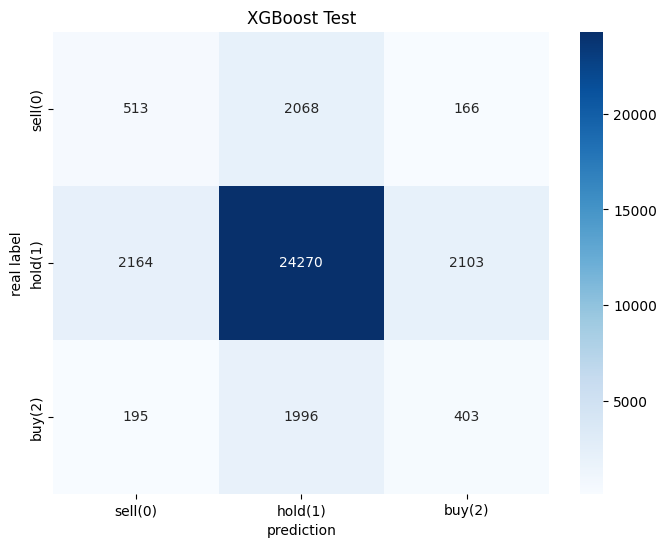

ÌÅ¥ÎûòÏä§Î≥Ñ Ï†ïÌôïÎèÑ:
  sell(0): 0.1867
  hold(1): 0.8505
  buy(2): 0.1554


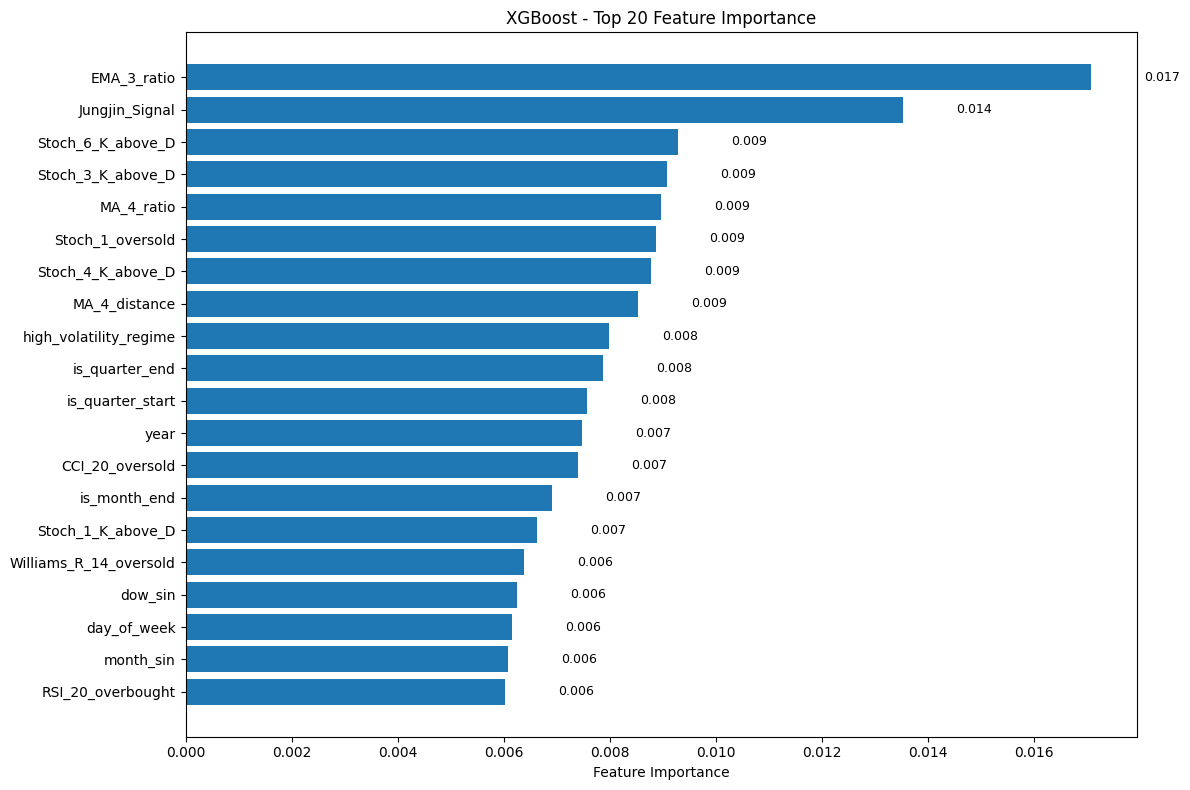

Top 20 Ï§ëÏöî ÌîºÏ≥ê:
   1. EMA_3_ratio: 0.0171
   2. Jungjin_Signal: 0.0135
   3. Stoch_6_K_above_D: 0.0093
   4. Stoch_3_K_above_D: 0.0091
   5. MA_4_ratio: 0.0090
   6. Stoch_1_oversold: 0.0089
   7. Stoch_4_K_above_D: 0.0088
   8. MA_4_distance: 0.0085
   9. high_volatility_regime: 0.0080
  10. is_quarter_end: 0.0079
  11. is_quarter_start: 0.0076
  12. year: 0.0075
  13. CCI_20_oversold: 0.0074
  14. is_month_end: 0.0069
  15. Stoch_1_K_above_D: 0.0066
  16. Williams_R_14_oversold: 0.0064
  17. dow_sin: 0.0063
  18. day_of_week: 0.0062
  19. month_sin: 0.0061
  20. RSI_20_overbought: 0.0060


In [68]:
# =============================================================================
# ÏÖÄ 9: ÌòºÎèô ÌñâÎ†¨ ÏãúÍ∞ÅÌôî
# =============================================================================

def plot_confusion_matrix(y_true, y_pred, save_path=None):
    """ÌòºÎèô ÌñâÎ†¨ ÏãúÍ∞ÅÌôî"""
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    
    # Ï†ïÍ∑úÌôîÎêú ÌòºÎèô ÌñâÎ†¨ÎèÑ ÌëúÏãú
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # ÌòºÎèô ÌñâÎ†¨ ÌûàÌä∏Îßµ
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['sell(0)', 'hold(1)', 'buy(2)'],
               yticklabels=['sell(0)', 'hold(1)', 'buy(2)'])
    plt.title('XGBoost Test')
    plt.xlabel('prediction')
    plt.ylabel('real label')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # ÌÅ¥ÎûòÏä§Î≥Ñ Ï†ïÌôïÎèÑ
    print("ÌÅ¥ÎûòÏä§Î≥Ñ Ï†ïÌôïÎèÑ:")
    for i, class_name in enumerate(['sell(0)', 'hold(1)', 'buy(2)']):
        accuracy = cm[i, i] / cm[i].sum()
        print(f"  {class_name}: {accuracy:.4f}")

# ÌòºÎèô ÌñâÎ†¨ ÏãúÍ∞ÅÌôî
plot_confusion_matrix(y_test, test_predictions, 
                     save_path=os.path.join(output_dir, 'confusion_matrix.png'))

# =============================================================================
# ÏÖÄ 10: ÌîºÏ≥ê Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôî
# =============================================================================

def plot_feature_importance(feature_importance, top_n=20, save_path=None):
    """ÌîºÏ≥ê Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôî"""
    
    # ÏÉÅÏúÑ NÍ∞ú ÌîºÏ≥ê
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    features, importances = zip(*sorted_features)
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(features)), importances)
    plt.yticks(range(len(features)), features)
    plt.xlabel('Feature Importance')
    plt.title(f'XGBoost - Top {top_n} Feature Importance')
    plt.gca().invert_yaxis()
    
    # Í∞í ÌëúÏãú
    for i, (bar, importance) in enumerate(zip(bars, importances)):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{importance:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # ÏÉÅÏúÑ ÌîºÏ≥êÎì§ Ï∂úÎ†•
    print(f"Top {top_n} Ï§ëÏöî ÌîºÏ≥ê:")
    for i, (feature, importance) in enumerate(sorted_features, 1):
        print(f"  {i:2d}. {feature}: {importance:.4f}")

# ÌîºÏ≥ê Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôî
plot_feature_importance(feature_importance, top_n=20, 
                       save_path=os.path.join(output_dir, 'feature_importance.png'))



# ÌîºÏ≥êÎ≥Ñ ÏÑ±Îä•ÌååÏïÖ + Í≥ºÏ†ÅÌï©Ï∞æÍ∏∞

In [69]:
# =============================================================================
# Îç∞Ïù¥ÌÑ∞ ÎàÑÏ∂ú Î∞è Í≥ºÏ†ÅÌï© ÏõêÏù∏ ÏßÑÎã® ÏΩîÎìú (Í∞úÏÑ†Î≤ÑÏ†Ñ)
# =============================================================================

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def diagnose_data_leakage(train_df, val_df, test_df, feature_columns):
    """
    Îç∞Ïù¥ÌÑ∞ ÎàÑÏ∂ú Î∞è Í≥ºÏ†ÅÌï© ÏõêÏù∏ ÏßÑÎã®
    """
    print("="*60)
    print("Îç∞Ïù¥ÌÑ∞ ÎàÑÏ∂ú ÏßÑÎã®")
    print("="*60)
    
    # 1. Future Í¥ÄÎ†® ÌîºÏ≤òÍ∞Ä Ïã§Ï†úÎ°ú Ï†úÍ±∞ÎêòÏóàÎäîÏßÄ ÌôïÏù∏
    future_features = [col for col in feature_columns if 'Future' in col]
    if future_features:
        print(f"‚ö†Ô∏è  Í≤ΩÍ≥†: Future Í¥ÄÎ†® ÌîºÏ≤òÍ∞Ä Ïó¨Ï†ÑÌûà Ìè¨Ìï®Îê®!")
        print(f"Future ÌîºÏ≤òÎì§: {future_features}")
    else:
        print("‚úÖ Future Í¥ÄÎ†® ÌîºÏ≤ò Î™®Îëê Ï†úÍ±∞Îê®")
    
    # 2. ÏãúÍ∞Ñ Ï†ïÎ≥¥ ÌôïÏù∏
    if 'Date' in train_df.columns:
        train_dates = pd.to_datetime(train_df['Date'])
        val_dates = pd.to_datetime(val_df['Date']) if not val_df.empty else None
        test_dates = pd.to_datetime(test_df['Date'])
        
        print(f"\nÏãúÍ∞ÑÏ†Å Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨:")
        print(f"Train Í∏∞Í∞Ñ: {train_dates.min()} ~ {train_dates.max()}")
        if val_dates is not None:
            print(f"Val Í∏∞Í∞Ñ:   {val_dates.min()} ~ {val_dates.max()}")
        print(f"Test Í∏∞Í∞Ñ:  {test_dates.min()} ~ {test_dates.max()}")
        
        # ÏãúÍ∞ÑÏ†Å ÏàúÏÑú ÌôïÏù∏
        train_max = train_dates.max()
        test_min = test_dates.min()
        
        if test_min <= train_max:
            print(f"‚ö†Ô∏è  Ïã¨Í∞ÅÌïú Î¨∏Ï†ú: ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Î≥¥Îã§ Ïù¥Î•∏ ÎÇ†ÏßúÍ∞Ä Ìè¨Ìï®Îê®!")
            print(f"   Train ÏµúÎåÄÏùº: {train_max}")
            print(f"   Test ÏµúÏÜåÏùº: {test_min}")
            
            # Í≤πÏπòÎäî ÎÇ†Ïßú ÌôïÏù∏
            overlapping_dates = set(train_dates.dt.date) & set(test_dates.dt.date)
            if overlapping_dates:
                print(f"   Í≤πÏπòÎäî ÎÇ†Ïßú Ïàò: {len(overlapping_dates)}Í∞ú")
                print(f"   Í≤πÏπòÎäî ÎÇ†Ïßú ÏÉòÌîå: {sorted(overlapping_dates)[:5]}")
        else:
            print("‚úÖ ÏãúÍ∞ÑÏ†Å ÏàúÏÑú Ïò¨Î∞îÎ¶Ñ (Train < Test)")
    
    # 3. ÌÉÄÍ≤ü Î≥ÄÏàò Î∂ÑÌè¨ ÎπÑÍµê
    print(f"\nÌÉÄÍ≤ü Î≥ÄÏàò Î∂ÑÌè¨ ÎπÑÍµê:")
    
    def print_distribution(name, y):
        dist = y.value_counts(normalize=True).sort_index() * 100
        print(f"{name:10s}: ", end="")
        for label in sorted(dist.index):
            print(f"{label}:{dist[label]:5.1f}% ", end="")
        print()
    
    print_distribution("Train", train_df['Future_Label'])
    if not val_df.empty:
        print_distribution("Val", val_df['Future_Label'])
    print_distribution("Test", test_df['Future_Label'])
    
    # 4. ÌäπÏ†ï ÌîºÏ≤òÏùò Î∂ÑÌè¨ ÌôïÏù∏ (ÎàÑÏ∂ú ÏùòÏã¨)
    suspicious_features = []
    for feature in feature_columns[:20]:  # Ï≤òÏùå 20Í∞ú Ï≤¥ÌÅ¨
        if feature in train_df.columns and feature in test_df.columns:
            train_mean = train_df[feature].mean()
            test_mean = test_df[feature].mean()
            
            if abs(train_mean - test_mean) / (abs(train_mean) + 1e-8) > 2.0:  # 200% Ïù¥ÏÉÅ Ï∞®Ïù¥
                suspicious_features.append(feature)
    
    if suspicious_features:
        print(f"\n‚ö†Ô∏è  Î∂ÑÌè¨Í∞Ä ÌÅ¨Í≤å Îã§Î•∏ ÌîºÏ≤òÎì§ (ÎàÑÏ∂ú ÏùòÏã¨):")
        for feature in suspicious_features[:10]:
            train_mean = train_df[feature].mean()
            test_mean = test_df[feature].mean()
            print(f"   {feature}: Train={train_mean:.4f}, Test={test_mean:.4f}")
    
    # 5. ÏôÑÏ†ÑÌûà ÎèôÏùºÌïú ÌñâÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
    print(f"\nÎç∞Ïù¥ÌÑ∞ Ï§ëÎ≥µ ÌôïÏù∏:")
    
    # ÌîºÏ≤òÎßåÏúºÎ°ú Ï§ëÎ≥µ ÌôïÏù∏
    train_features = train_df[feature_columns]
    test_features = test_df[feature_columns]
    
    # Ìï¥ÏãúÎ•º Ïù¥Ïö©Ìïú Îπ†Î•∏ Ï§ëÎ≥µ Í≤ÄÏÇ¨
    train_hashes = pd.util.hash_pandas_object(train_features, index=False)
    test_hashes = pd.util.hash_pandas_object(test_features, index=False)
    
    duplicate_count = len(set(train_hashes) & set(test_hashes))
    print(f"ÏôÑÏ†ÑÌûà ÎèôÏùºÌïú Ìñâ Ïàò: {duplicate_count}Í∞ú")
    
    if duplicate_count > 0:
        print(f"‚ö†Ô∏è  Ïã¨Í∞Å: TrainÍ≥º TestÏóê ÎèôÏùºÌïú ÌñâÏù¥ {duplicate_count}Í∞ú Ï°¥Ïû¨!")
    
    # 6. Ïã¨Î≥ºÎ≥Ñ Î∂ÑÌè¨ ÌôïÏù∏ (Ï£ºÏãù Îç∞Ïù¥ÌÑ∞Ïù∏ Í≤ΩÏö∞)
    if 'Symbol' in train_df.columns and 'Symbol' in test_df.columns:
        train_symbols = set(train_df['Symbol'].unique())
        test_symbols = set(test_df['Symbol'].unique())
        common_symbols = train_symbols & test_symbols
        
        print(f"\nSymbol Î∂ÑÌè¨:")
        print(f"Train Ïã¨Î≥º Ïàò: {len(train_symbols)}")
        print(f"Test Ïã¨Î≥º Ïàò: {len(test_symbols)}")
        print(f"Í≥µÌÜµ Ïã¨Î≥º Ïàò: {len(common_symbols)}")
        
        if len(common_symbols) == 0:
            print("‚ö†Ô∏è  Í≤ΩÍ≥†: TrainÍ≥º TestÏóê Í≥µÌÜµ Ïã¨Î≥ºÏù¥ ÏóÜÏùå (ÎèÑÎ©îÏù∏ Ï∞®Ïù¥ Í∞ÄÎä•ÏÑ±)")

    return {
        'future_features': future_features,
        'duplicate_rows': duplicate_count,
        'suspicious_features': suspicious_features
    }

# =============================================================================
# Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∂ÑÏÑù Ìï®Ïàò
# =============================================================================

def analyze_multicollinearity(X_data, feature_columns, max_features=50):
    """
    Îã§Ï§ëÍ≥µÏÑ†ÏÑ±(VIF) Î∂ÑÏÑù
    """
    print("\n" + "="*60)
    print("Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∂ÑÏÑù (VIF)")
    print("="*60)
    
    # ÎÑàÎ¨¥ ÎßéÏùÄ ÌîºÏ≤òÍ∞Ä ÏûàÏúºÎ©¥ ÏÉòÌîåÎßÅ
    if len(feature_columns) > max_features:
        print(f"ÌîºÏ≤òÍ∞Ä ÎÑàÎ¨¥ ÎßéÏïÑÏÑú ÏÉÅÏúÑ {max_features}Í∞úÎßå Î∂ÑÏÑùÌï©ÎãàÎã§.")
        # Î∂ÑÏÇ∞Ïù¥ ÌÅ∞ ÌîºÏ≤òÎì§ÏùÑ Ïö∞ÏÑ†Ï†ÅÏúºÎ°ú ÏÑ†ÌÉù
        feature_vars = X_data[feature_columns].var().sort_values(ascending=False)
        selected_features = feature_vars.head(max_features).index.tolist()
    else:
        selected_features = feature_columns
    
    # Í≤∞Ï∏°Í∞íÍ≥º Î¨¥ÌïúÍ∞í Ï≤òÎ¶¨
    X_clean = X_data[selected_features].copy()
    X_clean = X_clean.replace([np.inf, -np.inf], np.nan)
    X_clean = X_clean.fillna(X_clean.median())
    
    # Î∂ÑÏÇ∞Ïù¥ 0Ïù∏ ÌîºÏ≤ò Ï†úÍ±∞
    zero_var_features = X_clean.columns[X_clean.var() == 0].tolist()
    if zero_var_features:
        print(f"Î∂ÑÏÇ∞Ïù¥ 0Ïù∏ ÌîºÏ≤ò Ï†úÍ±∞: {len(zero_var_features)}Í∞ú")
        X_clean = X_clean.drop(columns=zero_var_features)
        selected_features = [f for f in selected_features if f not in zero_var_features]
    
    try:
        # VIF Í≥ÑÏÇ∞
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X_clean.columns
        vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) 
                          for i in range(len(X_clean.columns))]
        
        vif_data = vif_data.sort_values('VIF', ascending=False)
        
        # ÎÜíÏùÄ VIF ÌîºÏ≤òÎì§ (Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î¨∏Ï†ú)
        high_vif = vif_data[vif_data['VIF'] > 10]
        moderate_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]
        
        print("VIF Ìï¥ÏÑù:")
        print("  VIF < 5: Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î¨∏Ï†ú ÏóÜÏùå")
        print("  5 ‚â§ VIF ‚â§ 10: Ï§ëÍ∞Ñ Ï†ïÎèÑ Îã§Ï§ëÍ≥µÏÑ†ÏÑ±")
        print("  VIF > 10: ÎÜíÏùÄ Îã§Ï§ëÍ≥µÏÑ†ÏÑ± (Ï†úÍ±∞ Í≥†Î†§)")
        print()
        
        if not high_vif.empty:
            print(f"‚ö†Ô∏è  ÎÜíÏùÄ Îã§Ï§ëÍ≥µÏÑ†ÏÑ± ÌîºÏ≤òÎì§ (VIF > 10): {len(high_vif)}Í∞ú")
            for idx, row in high_vif.head(15).iterrows():
                print(f"   {row['Feature']:30s}: VIF = {row['VIF']:8.2f}")
        
        if not moderate_vif.empty:
            print(f"\nÏ§ëÍ∞Ñ Îã§Ï§ëÍ≥µÏÑ†ÏÑ± ÌîºÏ≤òÎì§ (5 < VIF ‚â§ 10): {len(moderate_vif)}Í∞ú")
            for idx, row in moderate_vif.head(10).iterrows():
                print(f"   {row['Feature']:30s}: VIF = {row['VIF']:8.2f}")
        
        return vif_data
        
    except Exception as e:
        print(f"VIF Í≥ÑÏÇ∞ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        print("ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ°ú ÎåÄÏ≤¥ Î∂ÑÏÑùÏùÑ ÏàòÌñâÌï©ÎãàÎã§.")
        
        # VIF Ïã§Ìå®Ïãú ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ°ú ÎåÄÏ≤¥
        corr_matrix = X_clean.corr().abs()
        high_corr_pairs = []
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > 0.9:  # ÎÜíÏùÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
                    high_corr_pairs.append((
                        corr_matrix.columns[i], 
                        corr_matrix.columns[j], 
                        corr_matrix.iloc[i, j]
                    ))
        
        if high_corr_pairs:
            print(f"\nÎÜíÏùÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌîºÏ≤ò ÏåçÎì§ (>0.9): {len(high_corr_pairs)}Í∞ú")
            for feat1, feat2, corr in high_corr_pairs[:10]:
                print(f"   {feat1} - {feat2}: {corr:.3f}")
        
        return None

# =============================================================================
# Í≥ºÏ†ÅÌï© ÏõêÏù∏ Î∂ÑÏÑù Ìï®Ïàò (Í∞úÏÑ†Î≤ÑÏ†Ñ)
# =============================================================================

def analyze_overfitting_causes(model, X_train_val, X_test, y_train_val, y_test, feature_columns):
    """
    Í≥ºÏ†ÅÌï©Ïùò Íµ¨Ï≤¥Ï†Å ÏõêÏù∏ Î∂ÑÏÑù (Permutation Importance Ìè¨Ìï®)
    """
    print("\n" + "="*60)
    print("Í≥ºÏ†ÅÌï© ÏõêÏù∏ Î∂ÑÏÑù")
    print("="*60)
    
    # 1. ÌîºÏ≤ò Ï§ëÏöîÎèÑ Î∂ÑÏÑù (ÏÉÅÏúÑ/ÌïòÏúÑ 20Í∞ú)
    feature_importance = model.feature_importances_
    feature_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("="*50)
    print("ÌîºÏ≤ò Ï§ëÏöîÎèÑ Î∂ÑÏÑù")
    print("="*50)
    
    print("\nüî• ÏÉÅÏúÑ 20Í∞ú Ï§ëÏöî ÌîºÏ≤ò:")
    for i, row in feature_imp_df.head(20).iterrows():
        print(f"  {i+1:2d}. {row['feature']:30s}: {row['importance']:.6f}")
    
    print("\n‚ùÑÔ∏è  ÌïòÏúÑ 20Í∞ú ÎÇÆÏùÄ Ï§ëÏöîÎèÑ ÌîºÏ≤ò:")
    for i, row in feature_imp_df.tail(20).iterrows():
        rank = len(feature_imp_df) - list(feature_imp_df.index).index(i)
        print(f"  {rank:2d}. {row['feature']:30s}: {row['importance']:.6f}")
    
    # 2. Îß§Ïö∞ ÎÜíÏùÄ Ï§ëÏöîÎèÑÎ•º Í∞ÄÏßÑ ÌîºÏ≤ò ÌôïÏù∏ (ÎàÑÏ∂ú ÏùòÏã¨)
    high_importance_threshold = 0.05  # 5% Ïù¥ÏÉÅ
    high_imp_features = feature_imp_df[feature_imp_df['importance'] > high_importance_threshold]
    
    if not high_imp_features.empty:
        print(f"\n‚ö†Ô∏è  Îß§Ïö∞ ÎÜíÏùÄ Ï§ëÏöîÎèÑ ÌîºÏ≤òÎì§ (>{high_importance_threshold:.1%}, ÎàÑÏ∂ú ÏùòÏã¨):")
        for i, row in high_imp_features.iterrows():
            print(f"  {row['feature']:30s}: {row['importance']:.4f} ({row['importance']*100:.1f}%)")
    
    # 3. Permutation Importance Î∂ÑÏÑù
    print("\n" + "="*50)
    print("Permutation Importance Î∂ÑÏÑù")
    print("="*50)
    print("(ÏÑ±Îä•Ïù¥ Ïò§ÌûàÎ†§ Ìñ•ÏÉÅÎêòÎäî ÌîºÏ≤ò = ÏïÖÏòÅÌñ• ÌîºÏ≤ò)")
    
    try:
        # Í∏∞Î≥∏ ÏÑ±Îä• Ï∏°Ï†ï
        y_pred_base = model.predict(X_test)
        base_score = accuracy_score(y_test, y_pred_base)
        print(f"Í∏∞Î≥∏ ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: {base_score:.4f}")
        
        # Permutation importance Í≥ÑÏÇ∞ (ÏãúÍ∞ÑÏù¥ Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏùå)
        print("Permutation importance Í≥ÑÏÇ∞ Ï§ë... (ÏãúÍ∞ÑÏù¥ Í±∏Î¶¥ Ïàò ÏûàÏäµÎãàÎã§)")
        
        # ÏÉòÌîåÎßÅÏùÑ ÌÜµÌï¥ ÏÜçÎèÑ Í∞úÏÑ†
        n_sample = min(1000, len(X_test))
        sample_idx = np.random.choice(len(X_test), n_sample, replace=False)
        X_test_sample = X_test.iloc[sample_idx]
        y_test_sample = y_test.iloc[sample_idx] if hasattr(y_test, 'iloc') else y_test[sample_idx]
        
        perm_importance = permutation_importance(
            model, X_test_sample, y_test_sample, 
            n_repeats=3, random_state=42, 
            scoring='accuracy'
        )
        
        perm_imp_df = pd.DataFrame({
            'feature': feature_columns,
            'perm_importance_mean': perm_importance.importances_mean,
            'perm_importance_std': perm_importance.importances_std
        }).sort_values('perm_importance_mean', ascending=True)  # ÎÇÆÏùÄ ÏàúÏÑúÎ°ú Ï†ïÎ†¨
        
        # ÏùåÏùò ÏòÅÌñ•ÏùÑ Ï£ºÎäî ÌîºÏ≤òÎì§ (permutation Ïãú ÏÑ±Îä•Ïù¥ Ìñ•ÏÉÅÎêòÎäî Í≤ÉÎì§)
        negative_impact = perm_imp_df[perm_imp_df['perm_importance_mean'] < -0.001]
        
        if not negative_impact.empty:
            print(f"\nüö® ÏïÖÏòÅÌñ• ÌîºÏ≤òÎì§ (Ï†úÍ±∞Ïãú ÏÑ±Îä• Ìñ•ÏÉÅ): {len(negative_impact)}Í∞ú")
            for i, row in negative_impact.head(15).iterrows():
                impact = row['perm_importance_mean']
                std = row['perm_importance_std']
                print(f"  {row['feature']:30s}: {impact:+.4f} (¬±{std:.4f})")
        else:
            print("\n‚úÖ Î™ÖÌôïÌïú ÏïÖÏòÅÌñ• ÌîºÏ≤òÎäî Î∞úÍ≤¨ÎêòÏßÄ ÏïäÏùå")
        
        # Í∞ÄÏû• Ï§ëÏöîÌïú ÌîºÏ≤òÎì§
        print(f"\nüåü Permutation Í∏∞Ï§Ä ÏÉÅÏúÑ 15Í∞ú Ï§ëÏöî ÌîºÏ≤ò:")
        for i, row in perm_imp_df.tail(15).iterrows():
            impact = row['perm_importance_mean']
            std = row['perm_importance_std']
            print(f"  {row['feature']:30s}: {impact:+.4f} (¬±{std:.4f})")
            
    except Exception as e:
        print(f"Permutation importance Í≥ÑÏÇ∞ Ïã§Ìå®: {e}")
        print("ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÑ∞Î°ú Ïù∏Ìïú Î©îÎ™®Î¶¨/ÏãúÍ∞Ñ Î¨∏Ï†úÏùº Ïàò ÏûàÏäµÎãàÎã§.")
    
    # 4. Î™®Îç∏ Î≥µÏû°ÎèÑ ÌôïÏù∏
    print("\n" + "="*50)
    print("Î™®Îç∏ Î≥µÏû°ÎèÑ Î∂ÑÏÑù")
    print("="*50)
    
    if hasattr(model, 'get_params'):
        params = model.get_params()
        complex_params = ['max_depth', 'n_estimators', 'min_child_weight', 
                         'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda']
        for param in complex_params:
            if param in params:
                print(f"  {param:20s}: {params[param]}")
    
    # 5. Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨ ÎπÑÍµê
    print(f"\nÎç∞Ïù¥ÌÑ∞ ÌÜµÍ≥Ñ ÎπÑÍµê:")
    train_stats = X_train_val.describe()
    test_stats = X_test.describe()
    
    print(f"{'ÌÜµÍ≥Ñ':15s} {'Train':>12s} {'Test':>12s} {'Ï∞®Ïù¥':>12s}")
    print("-" * 55)
    for stat in ['mean', 'std', 'min', 'max']:
        train_val = train_stats.loc[stat].mean()
        test_val = test_stats.loc[stat].mean()
        diff = abs(train_val - test_val) / (abs(train_val) + 1e-8)
        print(f"{stat:15s} {train_val:12.4f} {test_val:12.4f} {diff:12.2%}")

    return feature_imp_df, perm_imp_df if 'perm_imp_df' in locals() else None

# =============================================================================
# Ïã§Ìñâ ÏΩîÎìú
# =============================================================================

# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÎì§Ïù¥ ÌïÑÏöîÌï©ÎãàÎã§
print("Îç∞Ïù¥ÌÑ∞ ÎàÑÏ∂ú ÏßÑÎã®ÏùÑ ÏúÑÌï¥ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ Îã§Ïãú Î°úÎìúÌï©ÎãàÎã§...")

# Îç∞Ïù¥ÌÑ∞ Îã§Ïãú Î°úÎìú (ÏßÑÎã®Ïö©)
train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
val_df = pd.read_csv(os.path.join(data_dir, 'val_data.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))

# 1. Îç∞Ïù¥ÌÑ∞ ÎàÑÏ∂ú ÏßÑÎã®
leakage_results = diagnose_data_leakage(train_df, val_df, test_df, feature_columns)

# 2. Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î∂ÑÏÑù
vif_results = analyze_multicollinearity(X_train_val, feature_columns)

# 3. Í≥ºÏ†ÅÌï© ÏõêÏù∏ Î∂ÑÏÑù (Permutation Importance Ìè¨Ìï®)
feature_imp_results, perm_imp_results = analyze_overfitting_causes(
    final_model, X_train_val, X_test, y_train_val, y_test, feature_columns
)

print("\n" + "="*60)
print("ÏßÑÎã® ÏôÑÎ£å!")
print("="*60)
print("Ï£ºÏöî Î∞úÍ≤¨ÏÇ¨Ìï≠:")
print(f"- Future ÌîºÏ≤ò Ïàò: {len(leakage_results['future_features'])}")
print(f"- Ï§ëÎ≥µ Ìñâ Ïàò: {leakage_results['duplicate_rows']}")
print(f"- ÏùòÏã¨Ïä§Îü¨Ïö¥ ÌîºÏ≤ò Ïàò: {len(leakage_results['suspicious_features'])}")
if vif_results is not None:
    high_vif_count = len(vif_results[vif_results['VIF'] > 10])
    print(f"- ÎÜíÏùÄ Îã§Ï§ëÍ≥µÏÑ†ÏÑ± ÌîºÏ≤ò Ïàò: {high_vif_count}")
print("\nÏÉÅÏÑ∏Ìïú Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Ï∞∏Í≥†ÌïòÏó¨ ÌîºÏ≤òÎ•º ÏÑ†Î≥ÑÌïòÏÑ∏Ïöî!")

Îç∞Ïù¥ÌÑ∞ ÎàÑÏ∂ú ÏßÑÎã®ÏùÑ ÏúÑÌï¥ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ Îã§Ïãú Î°úÎìúÌï©ÎãàÎã§...
Îç∞Ïù¥ÌÑ∞ ÎàÑÏ∂ú ÏßÑÎã®
‚úÖ Future Í¥ÄÎ†® ÌîºÏ≤ò Î™®Îëê Ï†úÍ±∞Îê®

ÏãúÍ∞ÑÏ†Å Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨:
Train Í∏∞Í∞Ñ: 2015-01-01 00:00:00 ~ 2023-10-30 00:00:00
Val Í∏∞Í∞Ñ:   2023-10-30 00:00:00 ~ 2024-10-04 00:00:00
Test Í∏∞Í∞Ñ:  2024-10-04 00:00:00 ~ 2025-09-14 00:00:00
‚úÖ ÏãúÍ∞ÑÏ†Å ÏàúÏÑú Ïò¨Î∞îÎ¶Ñ (Train < Test)

ÌÉÄÍ≤ü Î≥ÄÏàò Î∂ÑÌè¨ ÎπÑÍµê:
Train     : 0.0:  7.1% 1.0: 85.8% 2.0:  7.1% 
Val       : 0.0:  7.6% 1.0: 84.8% 2.0:  7.6% 
Test      : 0.0:  8.1% 1.0: 84.2% 2.0:  7.7% 

‚ö†Ô∏è  Î∂ÑÌè¨Í∞Ä ÌÅ¨Í≤å Îã§Î•∏ ÌîºÏ≤òÎì§ (ÎàÑÏ∂ú ÏùòÏã¨):
   MA_2: Train=-0.0216, Test=0.0841
   MA_4: Train=-0.0216, Test=0.0841
   MA_6: Train=-0.0216, Test=0.0843
   MA_8: Train=-0.0216, Test=0.0845
   MA_13: Train=-0.0215, Test=0.0840
   MA_16: Train=-0.0214, Test=0.0834
   MA_20: Train=-0.0213, Test=0.0830
   MA_25: Train=-0.0212, Test=0.0824
   MA_29: Train=-0.0211, Test=0.0818
   MA_60: Train=-0.0206, Test=0.0807

Îç∞Ïù¥Ì

In [70]:
# =============================================================================
# ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ìö®Í≥º Î∂ÑÏÑù Î∞è Î¨∏Ï†ú ÏßÑÎã®
# =============================================================================

def analyze_class_weight_effect(model, X_train_val, X_test, y_train_val, y_test, class_weights):
    """
    ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπòÍ∞Ä Ïã§Ï†úÎ°ú Ìö®Í≥ºÎ•º ÎÇ¥Í≥† ÏûàÎäîÏßÄ Î∂ÑÏÑù
    """
    print("="*60)
    print("ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ìö®Í≥º Î∂ÑÏÑù")
    print("="*60)
    
    # 1. ÏòàÏ∏° ÌôïÎ•† Î∂ÑÌè¨ ÌôïÏù∏
    train_pred_proba = model.predict_proba(X_train_val)
    test_pred_proba = model.predict_proba(X_test)
    
    train_pred = model.predict(X_train_val)
    test_pred = model.predict(X_test)
    
    print("ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÌè¨:")
    print(f"{'Îç∞Ïù¥ÌÑ∞ÏÖã':10s} {'Sell(0)':>8s} {'Hold(1)':>8s} {'Buy(2)':>8s}")
    print("-" * 40)
    
    # Ïã§Ï†ú Î∂ÑÌè¨
    for name, y_true in [("Ïã§Ï†ú-Train", y_train_val), ("Ïã§Ï†ú-Test", y_test)]:
        counts = y_true.value_counts().sort_index()
        pcts = (counts / len(y_true) * 100)
        print(f"{name:10s} {pcts[0]:7.1f}% {pcts[1]:7.1f}% {pcts[2]:7.1f}%")
    
    # ÏòàÏ∏° Î∂ÑÌè¨
    for name, y_pred in [("ÏòàÏ∏°-Train", train_pred), ("ÏòàÏ∏°-Test", test_pred)]:
        counts = pd.Series(y_pred).value_counts().sort_index()
        pcts = (counts / len(y_pred) * 100)
        
        # ÎàÑÎùΩÎêú ÌÅ¥ÎûòÏä§ Ï≤òÎ¶¨
        for i in [0, 1, 2]:
            if i not in counts.index:
                counts[i] = 0
        counts = counts.sort_index()
        pcts = (counts / len(y_pred) * 100)
        
        print(f"{name:10s} {pcts[0]:7.1f}% {pcts[1]:7.1f}% {pcts[2]:7.1f}%")
    
    # 2. ÏòàÏ∏° ÌôïÎ•†Ïùò ÌèâÍ∑† ÌôïÏù∏
    print(f"\nÌèâÍ∑† ÏòàÏ∏° ÌôïÎ•†:")
    print(f"{'Îç∞Ïù¥ÌÑ∞ÏÖã':10s} {'Sell(0)':>8s} {'Hold(1)':>8s} {'Buy(2)':>8s}")
    print("-" * 40)
    
    train_prob_mean = train_pred_proba.mean(axis=0)
    test_prob_mean = test_pred_proba.mean(axis=0)
    
    print(f"{'Train':10s} {train_prob_mean[0]:8.3f} {train_prob_mean[1]:8.3f} {train_prob_mean[2]:8.3f}")
    print(f"{'Test':10s} {test_prob_mean[0]:8.3f} {test_prob_mean[1]:8.3f} {test_prob_mean[2]:8.3f}")
    
    # 3. ÌÅ¥ÎûòÏä§Î≥Ñ ÏÑ±Îä• ÏÉÅÏÑ∏ Î∂ÑÏÑù
    from sklearn.metrics import classification_report, confusion_matrix
    
    print(f"\nÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÏÉÅÏÑ∏ ÏÑ±Îä•:")
    print(classification_report(y_test, test_pred, 
                              target_names=['Sell(0)', 'Hold(1)', 'Buy(2)']))
    
    print(f"ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÌòºÎèô ÌñâÎ†¨:")
    cm = confusion_matrix(y_test, test_pred)
    print(f"{'':8s} {'Sell':>6s} {'Hold':>6s} {'Buy':>6s}")
    class_names = ['Sell', 'Hold', 'Buy']
    for i, row_name in enumerate(class_names):
        print(f"{row_name:8s}", end="")
        for j in range(3):
            print(f"{cm[i,j]:6d}", end="")
        print()
    
    # 4. ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπòÍ∞Ä Ï†úÎåÄÎ°ú ÏûëÎèôÌïòÎäîÏßÄ ÌôïÏù∏
    print(f"\nÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ìö®Í≥º Î∂ÑÏÑù:")
    print(f"ÏÑ§Ï†ïÎêú Í∞ÄÏ§ëÏπò: {class_weights}")
    
    # Ïã§Ï†ú ÏÜêÏã§ÏóêÏÑú ÌÅ¥ÎûòÏä§Î≥Ñ Í∏∞Ïó¨ÎèÑ Ï∂îÏ†ï
    # (Ï†ïÌôïÌïú Í≥ÑÏÇ∞ÏùÄ Î™®Îç∏ ÎÇ¥Î∂Ä Ï†ëÍ∑ºÏù¥ ÌïÑÏöîÌïòÏßÄÎßå, ÎåÄÎûµÏ†Å Ï∂îÏ†ï)
    
    # ÎßåÏïΩ Î™®Îì† ÌÅ¥ÎûòÏä§Î•º HoldÎ°ú ÏòàÏ∏°ÌñàÎã§Î©¥?
    naive_pred = np.ones_like(y_test)  # Î™®Îì† Í≤ÉÏùÑ Hold(1)Î°ú ÏòàÏ∏°
    naive_accuracy = accuracy_score(y_test, naive_pred)
    actual_accuracy = accuracy_score(y_test, test_pred)
    
    print(f"Naive ÏòàÏ∏° (Î™®Îëê Hold): {naive_accuracy:.4f}")
    print(f"Ïã§Ï†ú Î™®Îç∏ Ï†ïÌôïÎèÑ: {actual_accuracy:.4f}")
    print(f"Í∞úÏÑ† Ï†ïÎèÑ: {actual_accuracy - naive_accuracy:.4f}")
    
    if actual_accuracy - naive_accuracy < 0.01:  # 1% ÎØ∏Îßå Í∞úÏÑ†
        print("‚ö†Ô∏è Í≤ΩÍ≥†: ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπòÍ∞Ä Í±∞Ïùò Ìö®Í≥ºÎ•º ÎÇ¥ÏßÄ Î™ªÌïòÍ≥† ÏûàÏùå!")
        return False
    else:
        print("‚úÖ ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπòÍ∞Ä Ïñ¥Îäê Ï†ïÎèÑ Ìö®Í≥ºÎ•º ÎÇ¥Í≥† ÏûàÏùå")
        return True

# =============================================================================
# Îçî Í∞ïÎ†•Ìïú ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ìï¥Í≤∞ Î∞©Î≤ïÎì§
# =============================================================================

def suggest_improved_approaches():
    """
    ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Î¨∏Ï†úÏóê ÎåÄÌïú Îçî Í∞ïÎ†•Ìïú Ìï¥Í≤∞Ï±ÖÎì§
    """
    print(f"\n" + "="*60)
    print("ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Î¨∏Ï†ú - Í∞úÏÑ†Îêú Ìï¥Í≤∞Ï±ÖÎì§")
    print("="*60)
    
    print("1. Îçî Í∞ïÌïú ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò ÏÇ¨Ïö©:")
    print("   - ÌòÑÏû¨ Í∞ÄÏ§ëÏπòÎ•º 2-3Î∞∞ Îçî Í∞ïÌïòÍ≤å ÏÑ§Ï†ï")
    print("   - sklearnÏùò 'balanced' ÏòµÏÖò ÏÇ¨Ïö©")
    
    print("\n2. ÏÉòÌîåÎßÅ Í∏∞Î≤ï Ï†ÅÏö©:")
    print("   - SMOTE: ÏÜåÏàò ÌÅ¥ÎûòÏä§ Ïò§Î≤ÑÏÉòÌîåÎßÅ")
    print("   - RandomUnderSampler: Îã§Ïàò ÌÅ¥ÎûòÏä§ Ïñ∏ÎçîÏÉòÌîåÎßÅ")
    print("   - Ï°∞Ìï© Î∞©Î≤ï (SMOTEENN, SMOTETomek)")
    
    print("\n3. ÏûÑÍ≥ÑÍ∞í(Threshold) Ï°∞Ï†ï:")
    print("   - Í∏∞Î≥∏ 0.5 ÎåÄÏã† ÌÅ¥ÎûòÏä§Î≥Ñ ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í Ï∞æÍ∏∞")
    print("   - Precision-Recall Ïª§Î∏å ÌôúÏö©")
    
    print("\n4. ÌèâÍ∞Ä ÏßÄÌëú Î≥ÄÍ≤Ω:")
    print("   - Accuracy ÎåÄÏã† Macro F1-Score ÏÇ¨Ïö©")
    print("   - ÌÅ¥ÎûòÏä§Î≥Ñ F1-Score Í∞úÎ≥Ñ ÌôïÏù∏")
    print("   - Balanced Accuracy ÏÇ¨Ïö©")
    
    print("\n5. ÏïôÏÉÅÎ∏î Î∞©Î≤ï:")
    print("   - BalancedRandomForest")
    print("   - EasyEnsemble")
    print("   - ÌÅ¥ÎûòÏä§Î≥Ñ Î≥ÑÎèÑ Î™®Îç∏ ÌïôÏäµ")

# =============================================================================
# Í∞ïÌôîÎêú ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ïã§Ìóò
# =============================================================================

def train_with_stronger_weights(X_train_val, y_train_val, best_params):
    """
    Îçî Í∞ïÌïú ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπòÎ°ú Î™®Îç∏ Ïû¨ÌïôÏäµ
    """
    print(f"\n" + "="*60)
    print("Í∞ïÌôîÎêú ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπòÎ°ú Ïû¨ÌïôÏäµ")
    print("="*60)
    
    # 1. sklearnÏùò 'balanced' ÏòµÏÖò ÏãúÎèÑ
    print("1. sklearn 'balanced' Í∞ÄÏ§ëÏπò Ïã§Ìóò...")
    
    balanced_params = {
        **best_params,
        'objective': 'multi:softprob',
        'num_class': 3,
        'random_state': RANDOM_STATE,
        'eval_metric': 'mlogloss'
    }
    
    # XGBoostÎäî class_weightÎ•º ÏßÅÏ†ë ÏßÄÏõêÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú sample_weight ÏÇ¨Ïö©
    from sklearn.utils.class_weight import compute_sample_weight
    
    # 'balanced' ÏòµÏÖòÏúºÎ°ú ÏÉòÌîå Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
    sample_weights_balanced = compute_sample_weight('balanced', y_train_val)
    
    print(f"Balanced ÏÉòÌîå Í∞ÄÏ§ëÏπò ÌÜµÍ≥Ñ:")
    print(f"  ÌèâÍ∑†: {sample_weights_balanced.mean():.3f}")
    print(f"  ÏµúÏÜå: {sample_weights_balanced.min():.3f}")
    print(f"  ÏµúÎåÄ: {sample_weights_balanced.max():.3f}")
    print(f"  ÎπÑÏú® (ÏµúÎåÄ/ÏµúÏÜå): {sample_weights_balanced.max()/sample_weights_balanced.min():.1f}")
    
    # 2. ÏàòÎèôÏúºÎ°ú Îçî Í∞ïÌïú Í∞ÄÏ§ëÏπò ÏÑ§Ï†ï
    print(f"\n2. ÏàòÎèô Í∞ïÌôî Í∞ÄÏ§ëÏπò Ïã§Ìóò...")
    
    # Í∏∞Ï°¥ Í∞ÄÏ§ëÏπòÏùò 2Î∞∞Î°ú Í∑πÍ∞í Í∞ïÌôî
    enhanced_weights = {
        0: 15.0,  # Sell - Îçî Í∞ïÌïòÍ≤å
        1: 0.2,   # Hold - Îçî ÏïΩÌïòÍ≤å  
        2: 15.0   # Buy - Îçî Í∞ïÌïòÍ≤å
    }
    
    sample_weights_enhanced = np.array([enhanced_weights[label] for label in y_train_val])
    
    print(f"Í∞ïÌôîÎêú ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò: {enhanced_weights}")
    print(f"Í∞ïÌôîÎêú ÏÉòÌîå Í∞ÄÏ§ëÏπò ÌÜµÍ≥Ñ:")
    print(f"  ÌèâÍ∑†: {sample_weights_enhanced.mean():.3f}")
    print(f"  ÏµúÏÜå: {sample_weights_enhanced.min():.3f}")
    print(f"  ÏµúÎåÄ: {sample_weights_enhanced.max():.3f}")
    print(f"  ÎπÑÏú® (ÏµúÎåÄ/ÏµúÏÜå): {sample_weights_enhanced.max()/sample_weights_enhanced.min():.1f}")
    
    return sample_weights_balanced, sample_weights_enhanced, balanced_params

# =============================================================================
# Ïã§Ìñâ ÏΩîÎìú
# =============================================================================

# ÌòÑÏû¨ Î™®Îç∏Ïùò ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ìö®Í≥º Î∂ÑÏÑù
print("ÌòÑÏû¨ Î™®Îç∏Ïùò ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ìö®Í≥ºÎ•º Î∂ÑÏÑùÌï©ÎãàÎã§...")
weight_is_effective = analyze_class_weight_effect(
    final_model, X_train_val, X_test, y_train_val, y_test, class_weights
)

# Í∞úÏÑ† Î∞©Î≤ï Ï†úÏïà
suggest_improved_approaches()

# Îçî Í∞ïÌïú Í∞ÄÏ§ëÏπòÎ°ú Ïã§ÌóòÌï† Ï§ÄÎπÑ
if not weight_is_effective:
    print(f"\nÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ìö®Í≥ºÍ∞Ä Î∂ÄÏ°±Ìï©ÎãàÎã§. Îçî Í∞ïÌïú Î∞©Î≤ïÏùÑ ÏãúÎèÑÌï¥Î≥¥ÏÑ∏Ïöî.")
    sample_weights_balanced, sample_weights_enhanced, enhanced_params = train_with_stronger_weights(
        X_train_val, y_train_val, best_params
    )
    
    print(f"\nÎã§Ïùå Îã®Í≥Ñ:")
    print(f"1. ÏúÑÏùò Í∞ïÌôîÎêú Í∞ÄÏ§ëÏπòÎ°ú Î™®Îç∏ÏùÑ Îã§Ïãú ÌïôÏäµ")
    print(f"2. SMOTE Îì± ÏÉòÌîåÎßÅ Í∏∞Î≤ï Ï†ÅÏö©")
    print(f"3. ÏûÑÍ≥ÑÍ∞í Ï°∞Ï†ïÏúºÎ°ú ÏòàÏ∏° ÏµúÏ†ÅÌôî")
else:
    print(f"\nÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπòÍ∞Ä Ìö®Í≥ºÎ•º ÎÇ¥Í≥† ÏûàÏßÄÎßå, Ï∂îÍ∞Ä Í∞úÏÑ†Ïù¥ ÌïÑÏöîÌï† Ïàò ÏûàÏäµÎãàÎã§.")

ÌòÑÏû¨ Î™®Îç∏Ïùò ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ìö®Í≥ºÎ•º Î∂ÑÏÑùÌï©ÎãàÎã§...
ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ìö®Í≥º Î∂ÑÏÑù
ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÌè¨:
Îç∞Ïù¥ÌÑ∞ÏÖã        Sell(0)  Hold(1)   Buy(2)
----------------------------------------
Ïã§Ï†ú-Train       7.2%    85.7%     7.2%
Ïã§Ï†ú-Test        8.1%    84.2%     7.7%
ÏòàÏ∏°-Train      10.8%    78.9%    10.3%
ÏòàÏ∏°-Test        8.5%    83.6%     7.9%

ÌèâÍ∑† ÏòàÏ∏° ÌôïÎ•†:
Îç∞Ïù¥ÌÑ∞ÏÖã        Sell(0)  Hold(1)   Buy(2)
----------------------------------------
Train         0.185    0.633    0.182
Test          0.189    0.627    0.184

ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÏÉÅÏÑ∏ ÏÑ±Îä•:
              precision    recall  f1-score   support

     Sell(0)       0.18      0.19      0.18      2747
     Hold(1)       0.86      0.85      0.85     28537
      Buy(2)       0.15      0.16      0.15      2594

    accuracy                           0.74     33878
   macro avg       0.40      0.40      0.40     33878
weighted avg       0.75      0.74      0.75     33878

ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÌòºÎèô

In [71]:
# =============================================================================
# ÏÖÄ 11: Í≤∞Í≥º Ï†ÄÏû•
# =============================================================================

# =============================================================================
# ÏÖÄ 11: Í≤∞Í≥º Ï†ÄÏû• (ÏàòÏ†ï)
# =============================================================================
def save_results(model, best_params, evaluation_results, feature_importance, output_dir):
    """Í≤∞Í≥º Ï†ÄÏû• (JSON ÏßÅÎ†¨Ìôî Î¨∏Ï†ú Ìï¥Í≤∞)"""
    
    print("Í≤∞Í≥º Ï†ÄÏû• Ï§ë...")
    
    # Î™®Îç∏ Ï†ÄÏû•
    model_path = os.path.join(output_dir, 'xgboost_model.pkl')
    joblib.dump(model, model_path)
    print(f"  Î™®Îç∏ Ï†ÄÏû•: {model_path}")
    
    # ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû•
    params_path = os.path.join(output_dir, 'xgboost_best_params.json')
    with open(params_path, 'w') as f:
        json.dump(best_params, f, indent=2)
    print(f"  ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû•: {params_path}")
    
    # ÌèâÍ∞Ä Í≤∞Í≥º Ï†ÄÏû• (numpy ÌÉÄÏûÖ Î≥ÄÌôò)
    results_path = os.path.join(output_dir, 'xgboost_results.json')
    evaluation_results_serializable = {}
    for key, value in evaluation_results.items():
        if isinstance(value, dict):
            evaluation_results_serializable[key] = {k: float(v) if isinstance(v, (np.float32, np.float64)) else v 
                                                   for k, v in value.items()}
        else:
            evaluation_results_serializable[key] = float(value) if isinstance(value, (np.float32, np.float64)) else value
    
    with open(results_path, 'w') as f:
        json.dump(evaluation_results_serializable, f, indent=2)
    print(f"  ÌèâÍ∞Ä Í≤∞Í≥º Ï†ÄÏû•: {results_path}")
    
    # ÌîºÏ≥ê Ï§ëÏöîÎèÑ Ï†ÄÏû• (float32 ‚Üí float Î≥ÄÌôò)
    importance_path = os.path.join(output_dir, 'xgboost_feature_importance.json')
    feature_importance_serializable = {k: float(v) for k, v in feature_importance.items()}
    with open(importance_path, 'w') as f:
        json.dump(feature_importance_serializable, f, indent=2)
    print(f"  ÌîºÏ≥ê Ï§ëÏöîÎèÑ Ï†ÄÏû•: {importance_path}")
    
    # ÌîºÏ≥ê Î¶¨Ïä§Ìä∏ Ï†ÄÏû•
    features_path = os.path.join(output_dir, 'feature_list.json')
    with open(features_path, 'w') as f:
        json.dump({
            'feature_count': len(feature_columns),
            'feature_list': feature_columns
        }, f, indent=2)
    print(f"  ÌîºÏ≥ê Î¶¨Ïä§Ìä∏ Ï†ÄÏû•: {features_path}")

# Í≤∞Í≥º Ï†ÄÏû• Ïã§Ìñâ
save_results(final_model, best_params, evaluation_results, feature_importance, output_dir)

# =============================================================================
# ÏÖÄ 12: ÏµúÏ¢Ö ÏöîÏïΩ
# =============================================================================

print("\n" + "="*80)
print("XGBoost Ï£ºÏãù 3ÏßÑÎ∂ÑÎ•ò Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å")
print("="*80)

print(f"ÏôÑÎ£å ÏãúÍ∞Ñ: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ F1-Score: {evaluation_results['Test']['f1_macro']:.4f}")
print(f"ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: {evaluation_results['Test']['accuracy']:.4f}")
print(f"CV F1-Score: {evaluation_results['CV_F1_Score']:.4f}")
# print(f"Í≥ºÏ†ÅÌï© Ï†ïÎèÑ: {evaluation_results['Overfitting']:.4f}")

print(f"\nÏ†ÄÏû•Îêú ÌååÏùºÎì§:")
print(f"  - Î™®Îç∏: {output_dir}/xgboost_model.pkl")
print(f"  - ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {output_dir}/xgboost_best_params.json")
print(f"  - ÌèâÍ∞Ä Í≤∞Í≥º: {output_dir}/xgboost_results.json")
print(f"  - ÌîºÏ≥ê Ï§ëÏöîÎèÑ: {output_dir}/xgboost_feature_importance.json")

print("\nÎã§Ïùå Îã®Í≥Ñ: CatBoost Î™®Îç∏ ÌïôÏäµ ÎòêÎäî Î™®Îç∏ ÏïôÏÉÅÎ∏î")
print("="*80)

Í≤∞Í≥º Ï†ÄÏû• Ï§ë...
  Î™®Îç∏ Ï†ÄÏû•: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_model.pkl
  ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû•: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_best_params.json
  ÌèâÍ∞Ä Í≤∞Í≥º Ï†ÄÏû•: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_results.json
  ÌîºÏ≥ê Ï§ëÏöîÎèÑ Ï†ÄÏû•: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_feature_importance.json
  ÌîºÏ≥ê Î¶¨Ïä§Ìä∏ Ï†ÄÏû•: /workspace/AIÎ™®Îç∏/projects/coin/models/feature_list.json

XGBoost Ï£ºÏãù 3ÏßÑÎ∂ÑÎ•ò Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å
ÏôÑÎ£å ÏãúÍ∞Ñ: 2025-09-21 14:55:59
ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ F1-Score: 0.3964
ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: 0.7434
CV F1-Score: 0.4843

Ï†ÄÏû•Îêú ÌååÏùºÎì§:
  - Î™®Îç∏: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_model.pkl
  - ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_best_params.json
  - ÌèâÍ∞Ä Í≤∞Í≥º: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_results.json
  - ÌîºÏ≥ê Ï§ëÏöîÎèÑ: /workspace/AIÎ™®Îç∏/projects/coin/models/xgboost_feature_importance.json



In [38]:
output_dir

'/workspace/AIÎ™®Îç∏/projects/coin/models'

# ÏµúÏ¢ÖÌÖåÏä§Ìä∏ + Î∞±ÌÖåÏä§ÌåÖÏö© Îç∞Ïù¥ÌÑ∞ ÎßåÎì§Í∏∞

In [72]:
### test  full data ÎßåÎì§Í∏∞ - date, close Îì±Îì± Î™®ÎëêÌè¨Ìï®
# ÌïôÏäµÏö© Ï†ÑÏ≤¥Îç∞Ïù¥ÌÑ∞ (Train+Val+Test)Î°úÎìú ÌõÑ test setÎ≤îÏúÑÎßå Ï∂îÏ∂ú
train_path = '/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/xgboost_training_data.csv'
full_data = pd.read_csv(train_path)

# ÏãúÍ≥ÑÏó¥ ÏàúÏÑúÏóê ÎßûÍ≤å Ï∂îÏ∂ú
full_data = full_data.sort_values('Date')

# Í∏∞Ï°¥ C00_00ÏΩîÎìúÏóêÏÑú split_time_series_data() Ìï®ÏàòÏôÄ ÎèôÏùºÌïú ÎπÑÏú®(70:15:15)Î°ú Î∂ÑÌï†Ï†ê Í≥ÑÏÇ∞
# test setÎ≤îÏúÑÎßå Ï∂îÏ∂ú
n = len(full_data)
train_end = int(n * 0.7)
val_end = int(n * 0.85)
test_data_full = full_data.iloc[val_end:].copy()

# test(ÌîºÏ≥ê Îã§ ÏûàÎäî Î≤ÑÏ†Ñ) set Ï†ÄÏû•
test_output_path = '/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/test_data_full.csv'
test_data_full.to_csv(test_output_path, index=False)

# ÎÇ†Ïßú : 2021.09.13~, Ï¢ÖÎ™© : CVX ÌñâÎ∂ÄÌÑ∞ ÎÇòÏò§Î©¥ Îê® : C00_00 Ïä§ÌÅ¨Î¶ΩÌä∏ Ï∞∏Í≥†

In [73]:
# =============================================================================
# Î∞±ÌÖåÏä§ÌåÖ 1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è ÏòàÏ∏° Ïã§Ìñâ
# =============================================================================

import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Î∞±ÌÖåÏä§ÌåÖ 1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è ÏòàÏ∏° Ïã§Ìñâ")
print("=" * 60)

# 1. test_data_full.csv Î°úÎìú (Ïúó ÏÖÄÏóêÏÑú ÏÉùÏÑ±)
test_data_full_path = '/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/test_data_full.csv'
test_data_full = pd.read_csv(test_data_full_path)

print(f"ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: {test_data_full.shape}")
print(f"ÎÇ†Ïßú Î≤îÏúÑ: {test_data_full['Date'].min()} ~ {test_data_full['Date'].max()}")
print(f"Ï¢ÖÎ™© Ïàò: {test_data_full['Symbol'].nunique()}")
print(f"Ï¢ÖÎ™© Î¶¨Ïä§Ìä∏: {test_data_full['Symbol'].unique()}")

# 2. PredictionÏùÑ ÏúÑÌï¥, ÌïôÏäµÏãú ÏÇ¨Ïö©ÌñàÎçò ÌîºÏ≥êÎßå Ï∂îÏ∂ú (Ïù¥ÎØ∏ ÏÖÄ3ÏóêÏÑú Ï†ïÏùòÌïú feature_columns ÏÇ¨Ïö©)
print(f"\nÌïôÏäµÏö© ÌîºÏ≥ê Ï∂îÏ∂ú...")
print(f"Ï†ÑÏ≤¥ Ïª¨Îüº Ïàò: {len(test_data_full.columns)}")
print(f"ÏÇ¨Ïö©Ìï† ÌîºÏ≥ê Ïàò: {len(feature_columns)}")


Î∞±ÌÖåÏä§ÌåÖ 1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è ÏòàÏ∏° Ïã§Ìñâ
ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: (33878, 386)
ÎÇ†Ïßú Î≤îÏúÑ: 2024-10-04 ~ 2025-09-14
Ï¢ÖÎ™© Ïàò: 99
Ï¢ÖÎ™© Î¶¨Ïä§Ìä∏: ['KNC' 'AAVE' 'SOL' '1INCH' 'AVAX' 'ENJ' 'FIL' 'OP' 'AXS' 'NEO' 'XTZ'
 'ALGO' 'IOTA' 'LEO' 'ANKR' 'ETC' 'ZRX' 'BAT' 'DASH' 'NEAR' 'SUSHI' 'REQ'
 'YFI' 'FLOW' 'ADA' 'CVX' 'ZEC' 'GRT6719' 'BCH' 'XLM' 'KCS' 'FET' 'QTUM'
 'ASTR' 'LTC' 'BAL' 'XYO' 'USDC' 'XRP' 'SPELL' 'TRX' 'SHIB' 'API3' 'TRAC'
 'THETA' 'BAND' 'CVC' 'XMR' 'FXS' 'SAND' 'ICP' 'CRO' 'RSR' 'DOGE' 'INJ'
 'ETH' 'OKB' 'HBAR' 'DAI' 'LRC' 'RLC' 'ATOM' 'TON11419' 'BNB' 'BNT' 'GNO'
 'SUI20947' 'LPT' 'MANA' 'STORJ' 'ARB11841' 'VET' 'CAKE' 'COTI' 'MNT27075'
 'KEEP' 'QNT' 'USDT' 'WAVES' 'EGLD' 'CRV' 'IMX10603' 'FTM' 'DYDX' 'SNX'
 'TORN' 'UNI7083' 'NMR' 'UMA' 'ZIL' 'CFG' 'CKB' 'BTC' 'BSV' 'DOT'
 'APT21794' 'STX4847' 'RUNE' 'CHZ']

ÌïôÏäµÏö© ÌîºÏ≥ê Ï∂îÏ∂ú...
Ï†ÑÏ≤¥ Ïª¨Îüº Ïàò: 386
ÏÇ¨Ïö©Ìï† ÌîºÏ≥ê Ïàò: 218


## Î™®Îç∏ÏòàÏ∏°(ÏµúÏ¢Ötest)

In [74]:

# ÌîºÏ≥ê Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X_backtest = test_data_full[feature_columns].fillna(0)
X_backtest = X_backtest.replace([np.inf, -np.inf], 0)

print(f"Î∞±ÌÖåÏä§ÌåÖÏö© ÌîºÏ≥ê Îç∞Ïù¥ÌÑ∞: {X_backtest.shape}")

# 3. Î™®Îç∏Î°ú ÏòàÏ∏° Ïã§Ìñâ
print(f"\nÏòàÏ∏° Ïã§Ìñâ Ï§ë...")

# ÎùºÎ≤®ÏòàÏ∏°
predictions = final_model.predict(X_backtest)
# ÌòïÌÉú: NumPy 1D Î∞∞Ïó¥
# ÏòàÏãú: array([1, 2, 0, 1, 2, 0, ...])  # Í∏∏Ïù¥ = ÏÉòÌîå Ïàò : (12543,) Í∞ôÏùÄ ÌòïÌÉú

# ÌôïÎ•†ÏòàÏ∏°
prediction_probabilities = final_model.predict_proba(X_backtest) # (12543, 3) Í∞ôÏùÄ ÌòïÌÉú
# ÌòïÌÉú: NumPy 2D Î∞∞Ïó¥ (ÏÉòÌîå Ïàò √ó ÌÅ¥ÎûòÏä§ Ïàò)
# ÏòàÏãú: array([[0.2, 0.7, 0.1],   # Ï≤´ Î≤àÏß∏ ÏÉòÌîå: Sell=0.2, Hold=0.7, Buy=0.1
#              [0.1, 0.3, 0.6],   # Îëê Î≤àÏß∏ ÏÉòÌîå: Sell=0.1, Hold=0.3, Buy=0.6
#              ...])

print(f"ÏòàÏ∏° ÏôÑÎ£å!")
print(f"ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÌè¨:")
unique, counts = np.unique(predictions, return_counts=True)
for label, count in zip(unique, counts):
    label_name = {0: 'Sell', 1: 'Hold', 2: 'Buy'}[int(label)]
    pct = count / len(predictions) * 100
    print(f"  {int(label)} ({label_name}): {count:,}Í∞ú ({pct:.1f}%)")

Î∞±ÌÖåÏä§ÌåÖÏö© ÌîºÏ≥ê Îç∞Ïù¥ÌÑ∞: (33878, 218)

ÏòàÏ∏° Ïã§Ìñâ Ï§ë...
ÏòàÏ∏° ÏôÑÎ£å!
ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÌè¨:
  0 (Sell): 2,872Í∞ú (8.5%)
  1 (Hold): 28,334Í∞ú (83.6%)
  2 (Buy): 2,672Í∞ú (7.9%)


In [75]:

# 4. ÏòàÏ∏° Í≤∞Í≥ºÎ•º ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Ïóê Ï∂îÍ∞Ä
# 1D Î∞∞Ïó¥ÏùÑ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ïª¨ÎüºÏúºÎ°ú Ï∂îÍ∞Ä
test_data_full['Predicted_Label'] = predictions

# 2D Î∞∞Ïó¥ÏóêÏÑú Í∞Å ÌÅ¥ÎûòÏä§Î≥ÑÎ°ú Ïª¨Îüº Ï∂îÍ∞Ä
test_data_full['Pred_Prob_Sell'] = prediction_probabilities[:, 0]
test_data_full['Pred_Prob_Hold'] = prediction_probabilities[:, 1]
test_data_full['Pred_Prob_Buy'] = prediction_probabilities[:, 2]

# ÏòàÏ∏° Ïã†Ìò∏Î•º ÌÖçÏä§Ìä∏Î°ú Î≥ÄÌôò
label_map = {0: 'Sell', 1: 'Hold', 2: 'Buy'}
test_data_full['Predicted_Action'] = test_data_full['Predicted_Label'].map(label_map)

print(f"\nÏòàÏ∏° Í≤∞Í≥ºÍ∞Ä Ï∂îÍ∞ÄÎêú Îç∞Ïù¥ÌÑ∞: {test_data_full.shape}")

# 5. Ïã§Ï†ú ÎùºÎ≤®Í≥º ÎπÑÍµê (Í≤ÄÏ¶ùÏö©)
if 'Future_Label' in test_data_full.columns:
    actual_labels = test_data_full['Future_Label']
    test_accuracy = accuracy_score(actual_labels, predictions)
    test_f1 = f1_score(actual_labels, predictions, average='macro')
    
    print(f"\nÏòàÏ∏° ÏÑ±Îä• Í≤ÄÏ¶ù:")
    print(f"  Ï†ïÌôïÎèÑ: {test_accuracy:.4f}")
    print(f"  F1 Score: {test_f1:.4f}")
    
    print(f"\nÏÉÅÏÑ∏ Î∂ÑÎ•ò Î≥¥Í≥†ÏÑú:")
    print(classification_report(actual_labels, predictions, 
                               target_names=['Sell', 'Hold', 'Buy']))

# 6. ÏòàÏ∏° Í≤∞Í≥ºÍ∞Ä Ï∂îÍ∞ÄÎêú Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
output_path = '/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/test_data_with_predictions.csv'
test_data_full.to_csv(output_path, index=False)
print(f"\nÏòàÏ∏° Í≤∞Í≥ºÍ∞Ä Ï∂îÍ∞ÄÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•: {output_path}")

# 7. Î∞±ÌÖåÏä§ÌåÖÏö© ÌïµÏã¨ Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú
backtest_data = test_data_full[['Date', 'Symbol', 'Close', 'Predicted_Label', 
                               'Predicted_Action', 'Pred_Prob_Sell', 
                               'Pred_Prob_Hold', 'Pred_Prob_Buy']].copy()

# Date Ïª¨ÎüºÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôò
backtest_data['Date'] = pd.to_datetime(backtest_data['Date'])

# ÏãúÍ∞ÑÏàú Ï†ïÎ†¨
backtest_data = backtest_data.sort_values(['Symbol', 'Date']).reset_index(drop=True)

print(f"\nÎ∞±ÌÖåÏä§ÌåÖÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å: {backtest_data.shape}")
print(f"ÏÉòÌîå Îç∞Ïù¥ÌÑ∞:")
print(backtest_data.head(10))

# 8. Î∞±ÌÖåÏä§ÌåÖÏö© Í∞ÑÎã® Îç∞Ïù¥ÌÑ∞ÎèÑ Î≥ÑÎèÑ Ï†ÄÏû•
simple_backtest_path = '/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/only_prediction_data.csv'
backtest_data.to_csv(simple_backtest_path, index=False)
print(f"Î∞±ÌÖåÏä§ÌåÖÏö© Í∞ÑÎã® Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•: {simple_backtest_path}")

print(f"\n1Îã®Í≥Ñ ÏôÑÎ£å!")


ÏòàÏ∏° Í≤∞Í≥ºÍ∞Ä Ï∂îÍ∞ÄÎêú Îç∞Ïù¥ÌÑ∞: (33878, 391)

ÏòàÏ∏° ÏÑ±Îä• Í≤ÄÏ¶ù:
  Ï†ïÌôïÎèÑ: 0.7434
  F1 Score: 0.3964

ÏÉÅÏÑ∏ Î∂ÑÎ•ò Î≥¥Í≥†ÏÑú:
              precision    recall  f1-score   support

        Sell       0.18      0.19      0.18      2747
        Hold       0.86      0.85      0.85     28537
         Buy       0.15      0.16      0.15      2594

    accuracy                           0.74     33878
   macro avg       0.40      0.40      0.40     33878
weighted avg       0.75      0.74      0.75     33878


ÏòàÏ∏° Í≤∞Í≥ºÍ∞Ä Ï∂îÍ∞ÄÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•: /workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/test_data_with_predictions.csv

Î∞±ÌÖåÏä§ÌåÖÏö© Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å: (33878, 8)
ÏÉòÌîå Îç∞Ïù¥ÌÑ∞:
        Date Symbol     Close  Predicted_Label Predicted_Action  \
0 2024-10-04  1INCH  0.257626                1             Hold   
1 2024-10-05  1INCH  0.256879                1             Hold   
2 2024-10-06  1INCH  0.262824                1             Hold   
3 2024-10-07  

In [76]:
display(test_data_full.head(10))
display(test_data_full.tail(10))

Open        High         Low       Close        Volume      MA_2  \
0    0.424843    0.444959    0.423797    0.444362  1.269084e+07 -0.115093   
1  143.359146  152.621704  141.889175  151.258560  2.869474e+08 -0.086776   
2  136.785187  144.426788  136.075638  143.172272  2.361841e+09 -0.088189   
3    0.246466    0.259227    0.244678    0.257626  1.695593e+07 -0.115128   
4   24.653477   26.485601   24.465038   26.241280  3.335036e+08 -0.110270   
5    0.140997    0.150680    0.140567    0.148675  1.277910e+07 -0.115148   
6    3.570434    3.651269    3.550582    3.645158  1.026214e+08 -0.114481   
7    1.518692    1.621835    1.513594    1.605315  1.386046e+08 -0.114875   
8    4.500671    4.687431    4.484663    4.662215  2.936479e+07 -0.114293   
9    9.656195    9.976046    9.547131    9.965290  2.438288e+07 -0.113285   

       MA_3      MA_4      MA_5      MA_6      MA_7      MA_8     MA_10  \
0 -0.115083 -0.115089 -0.115057 -0.115050 -0.115015 -0.114991 -0.114988   
1 -0.087275 -0.087247 -0.086768 -0.086293 -0.085864 -0.085379 -0.084916   
2 -0.088148 -0.087892 -0.087433 -0.086938 -0.086613 -0.086347 -0.086214   
3 -0.115118 -0.115124 -0.115092 -0.115086 -0.115051 -0.115028 -0.115025   
4 -0.110264 -0.110247 -0.110132 -0.110026 -0.109915 -0.109806 -0.109767   
5 -0.115139 -0.115145 -0.115113 -0.115107 -0.115073 -0.115050 -0.115048   
6 -0.114475 -0.114482 -0.114443 -0.114423 -0.114377 -0.114345 -0.114334   
7 -0.114864 -0.114865 -0.114829 -0.114815 -0.114775 -0.114748 -0.114746   
8 -0.114283 -0.114283 -0.114236 -0.114205 -0.114156 -0.114121 -0.114108   
9 -0.113284 -0.113286 -0.113223 -0.113190 -0.113134 -0.113094 -0.113078   

      MA_13     MA_16     MA_20     MA_25     MA_29     MA_50     MA_60  \
0 -0.115144 -0.115302 -0.115411 -0.115571 -0.115703 -0.115936 -0.115897   
1 -0.084481 -0.084748 -0.085378 -0.085724 -0.086369 -0.088067 -0.089270   
2 -0.086352 -0.086500 -0.087150 -0.087536 -0.087940 -0.087746 -0.087363   
3 -0.115182 -0.115342 -0.115450 -0.115609 -0.115740 -0.115974 -0.115934   
4 -0.109894 -0.110040 -0.110269 -0.110499 -0.110714 -0.111103 -0.111161   
5 -0.115206 -0.115366 -0.115473 -0.115632 -0.115764 -0.115997 -0.115957   
6 -0.114492 -0.114651 -0.114769 -0.114929 -0.115066 -0.115290 -0.115249   
7 -0.114903 -0.115063 -0.115178 -0.115340 -0.115475 -0.115721 -0.115686   
8 -0.114262 -0.114419 -0.114538 -0.114703 -0.114846 -0.115069 -0.115029   
9 -0.113234 -0.113394 -0.113533 -0.113700 -0.113845 -0.114051 -0.114018   

     MA_100    MA_120    MA_200     EMA_3     EMA_4     EMA_5     EMA_6  \
0 -0.115389 -0.115001 -0.116776 -0.115081 -0.115048 -0.115029 -0.115026   
1 -0.091453 -0.092034 -0.093173 -0.086639 -0.086532 -0.086363 -0.086191   
2 -0.085459 -0.085088 -0.083325 -0.087770 -0.087580 -0.087395 -0.087244   
3 -0.115422 -0.115037 -0.116818 -0.115117 -0.115084 -0.115065 -0.115062   
4 -0.110373 -0.109841 -0.109966 -0.110181 -0.110121 -0.110067 -0.110032   
5 -0.115453 -0.115069 -0.116847 -0.115138 -0.115105 -0.115086 -0.115084   
6 -0.114695 -0.114272 -0.115769 -0.114466 -0.114431 -0.114407 -0.114401   
7 -0.115167 -0.114771 -0.116443 -0.114858 -0.114823 -0.114801 -0.114796   
8 -0.114442 -0.114009 -0.115471 -0.114269 -0.114229 -0.114202 -0.114192   
9 -0.113412 -0.112954 -0.114081 -0.113259 -0.113219 -0.113190 -0.113179   

      EMA_7    EMA_10    EMA_12    EMA_20    EMA_24    EMA_26    EMA_50  \
0 -0.115039 -0.115213 -0.115354 -0.115641 -0.115701 -0.115744 -0.115972   
1 -0.086044 -0.085822 -0.085799 -0.086077 -0.086320 -0.086465 -0.088172   
2 -0.087134 -0.087038 -0.087075 -0.087298 -0.087371 -0.087405 -0.087280   
3 -0.115075 -0.115250 -0.115391 -0.115679 -0.115739 -0.115782 -0.116010   
4 -0.110016 -0.110128 -0.110247 -0.110545 -0.110630 -0.110684 -0.110965   
5 -0.115097 -0.115272 -0.115414 -0.115702 -0.115762 -0.115805 -0.116034   
6 -0.114410 -0.114577 -0.114715 -0.114998 -0.115057 -0.115099 -0.115313   
7 -0.114807 -0.114979 -0.115119 -0.115409 -0.115470 -0.115513 -0.115746   
8 -0.114

Open        High         Low       Close      Volume      MA_2  \
33868    0.252974    0.253388    0.238841    0.239569  92478920.0 -0.115129   
33869    9.585751    9.599973    9.504026    9.522363    590843.0 -0.113334   
33870    0.249371    0.250006    0.235564    0.236217  53610587.0 -0.115130   
33871    1.437121    1.438450    1.355240    1.365795  14938297.0 -0.114906   
33872    1.284610    1.315996    1.270315    1.270470   6176615.0 -0.114930   
33873  286.057922  308.376526  284.875214  306.040314  93520562.0 -0.058099   
33874    0.056362    0.056535    0.052670    0.052866  18103800.0 -0.115166   
33875    0.382281    0.385285    0.372325    0.376430   1910928.0 -0.115103   
33876   26.908287   27.341433   26.271624   26.489660  47421402.0 -0.110029   
33877    0.284507    0.284810    0.271429    0.273399  29872924.0 -0.115123   

           MA_3      MA_4      MA_5      MA_6      MA_7      MA_8     MA_10  \
33868 -0.115119 -0.115125 -0.115095 -0.115090 -0.115057 -0.115035 -0.115033   
33869 -0.113322 -0.113328 -0.113298 -0.113292 -0.113259 -0.113237 -0.113234   
33870 -0.115119 -0.115125 -0.115094 -0.115088 -0.115055 -0.115032 -0.115030   
33871 -0.114895 -0.114901 -0.114870 -0.114866 -0.114833 -0.114812 -0.114812   
33872 -0.114918 -0.114926 -0.114897 -0.114894 -0.114861 -0.114839 -0.114838   
33873 -0.058859 -0.059884 -0.060546 -0.061053 -0.061406 -0.061541 -0.061832   
33874 -0.115156 -0.115163 -0.115132 -0.115127 -0.115093 -0.115071 -0.115069   
33875 -0.115093 -0.115100 -0.115070 -0.115065 -0.115032 -0.115010 -0.115009   
33876 -0.110019 -0.110040 -0.110026 -0.110045 -0.110028 -0.110026 -0.110051   
33877 -0.115113 -0.115119 -0.115089 -0.115084 -0.115050 -0.115027 -0.115026   

          MA_13     MA_16     MA_20     MA_25     MA_29     MA_50     MA_60  \
33868 -0.115191 -0.115351 -0.115457 -0.115615 -0.115745 -0.115977 -0.115935   
33869 -0.113385 -0.113537 -0.113638 -0.113788 -0.113912 -0.114162 -0.114126   
33870 -0.115186 -0.115345 -0.115451 -0.115615 -0.115748 -0.115987 -0.115950   
33871 -0.114970 -0.115127 -0.115230 -0.115384 -0.115515 -0.115756 -0.115713   
33872 -0.114994 -0.115153 -0.115257 -0.115411 -0.115540 -0.115766 -0.115724   
33873 -0.062036 -0.062513 -0.062490 -0.062541 -0.062560 -0.061070 -0.059186   
33874 -0.115227 -0.115386 -0.115493 -0.115652 -0.115783 -0.116016 -0.115975   
33875 -0.115166 -0.115326 -0.115432 -0.115589 -0.115718 -0.115944 -0.115901   
33876 -0.110199 -0.110345 -0.110408 -0.110525 -0.110605 -0.110665 -0.110524   
33877 -0.115183 -0.115344 -0.115451 -0.115610 -0.115742 -0.115975 -0.115934   

         MA_100    MA_120    MA_200     EMA_3     EMA_4     EMA_5     EMA_6  \
33868 -0.115439 -0.115058 -0.116853 -0.115119 -0.115087 -0.115068 -0.115066   
33869 -0.113621 -0.113244 -0.114889 -0.113324 -0.113292 -0.113273 -0.113270   
33870 -0.115456 -0.115076 -0.116875 -0.115119 -0.115086 -0.115067 -0.115065   
33871 -0.115224 -0.114844 -0.116628 -0.114897 -0.114864 -0.114846 -0.114844   
33872 -0.115242 -0.114862 -0.116636 -0.114920 -0.114888 -0.114870 -0.114868   
33873 -0.054979 -0.052359 -0.055974 -0.058543 -0.059220 -0.059729 -0.060126   
33874 -0.115474 -0.115092 -0.116887 -0.115156 -0.115123 -0.115105 -0.115103   
33875 -0.115406 -0.115023 -0.116815 -0.115093 -0.115061 -0.115043 -0.115041   
33876 -0.109780 -0.109119 -0.110075 -0.110042 -0.110020 -0.110013 -0.110020   
33877 -0.115435 -0.115053 -0.116845 -0.115112 -0.115080 -0.115061 -0.115059   

          EMA_7    EMA_10    EMA_12    EMA_20    EMA_24    EMA_26    EMA_50  \
33868 -0.115079 -0.115255 -0.115397 -0.115685 -0.115744 -0.115787 -0.116017   
33869 -0.113282 -0.113451 -0.113587 -0.113866 -0.113924 -0.113966 -0.114194   
33870 -0.115077 -0.115253 -0.115395 -0.115684 -0.115745 -0.115788 -0.116024   
33871 -0.114857 -0.115032 -0.115173 -0.115460 -0.115519 -0.115562 -0.115794   
33872 -0.114882 -0.115057 -0.115198 -0.115484 -0.115542 -0.115584 -0.115812   
33873 -0.060443 -0.061110 -0.061404 -0.061914 -0.061915 -0.

# Ï¢ÖÎ™©Î≥Ñ Ï†ÄÏû• : ÏòàÏ∏°Ïª¨ÎüºÏù¥ Ìè¨Ìï®Îêú csv Ï¢ÖÎ™©Î≥ÑÎ°ú Ï†ÄÏû•

In [77]:
# =============================================================================
# Ï¢ÖÎ™©Î≥Ñ ÏòàÏ∏° Í≤∞Í≥º CSV ÌååÏùº ÏÉùÏÑ±
# =============================================================================

import pandas as pd
import os

print("Ï¢ÖÎ™©Î≥Ñ ÏòàÏ∏° Í≤∞Í≥º CSV ÌååÏùº ÏÉùÏÑ±")
print("=" * 60)

# 1. backtest_data Î°úÎìú 
# backtest_dataÍ∞Ä ÏóÜÎã§Î©¥ ÏïÑÎûò Ï£ºÏÑù Ìï¥Ï†ú
backtest_data_path = '/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/test_data_with_predictions.csv'
backtest_data = pd.read_csv(backtest_data_path)
backtest_data['Date'] = pd.to_datetime(backtest_data['Date'])

Ï¢ÖÎ™©Î≥Ñ ÏòàÏ∏° Í≤∞Í≥º CSV ÌååÏùº ÏÉùÏÑ±


In [78]:
# ÏõêÎ≥∏ Î∞±ÌÖåÏä§ÌåÖ Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú
backtest_dir = '/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/backtest_data'

# Ïù¥ Ìè¥ÎçîÏóêÎäî Í∞Å Ï¢ÖÎ™©Î≥ÑÎ°ú ÏõêÎ≥∏ Close Í∞ÄÍ≤©Ïù¥ Ï†ÄÏû•ÎêòÏñ¥ ÏûàÏùå:
# AAPL_backtest.csv, MSFT_backtest.csv Îì±...

In [79]:
import pandas as pd
import os
import glob

# 1. ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞ Î°úÎìú
prediction_data = pd.read_csv('/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/test_data_with_predictions.csv')
prediction_cols = ['Date', 'Symbol', 'Predicted_Label', 'Predicted_Action', 'Pred_Prob_Sell', 'Pred_Prob_Hold', 'Pred_Prob_Buy']
predictions = prediction_data[prediction_cols].copy()
predictions['Date'] = pd.to_datetime(predictions['Date'])

# 2. Î∞±ÌÖåÏä§ÌåÖ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Ìè¥Îçî
backtest_dir = '/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/backtest_data'
backtest_files = glob.glob(os.path.join(backtest_dir, '*_backtest.csv'))

# 3. Ï¢ÖÎ™©Î≥ÑÎ°ú ÏõêÎ≥∏ Í∞ÄÍ≤© + ÏòàÏ∏° Í≤∞Ìï©
output_dir = '/workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/final_backtest_data'
os.makedirs(output_dir, exist_ok=True)

for backtest_file in backtest_files:
    # Ï¢ÖÎ™©Î™Ö Ï∂îÏ∂ú
    filename = os.path.basename(backtest_file)
    symbol = filename.replace('_backtest.csv', '')
    
    print(f"Ï≤òÎ¶¨ Ï§ë: {symbol}")
    
    # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú (Ïã§Ï†ú Close Í∞ÄÍ≤©)
    original_data = pd.read_csv(backtest_file)
    original_data['Date'] = pd.to_datetime(original_data['Date'])
    
    # Symbol Ïª¨Îüº Ï∂îÍ∞Ä (Î∞±ÌÖåÏä§ÌåÖ Îç∞Ïù¥ÌÑ∞Ïóê ÏóÜÏúºÎØÄÎ°ú)
    original_data['Symbol'] = symbol
    
    # Ìï¥Îãπ Ï¢ÖÎ™©Ïùò ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞
    symbol_predictions = predictions[predictions['Symbol'] == symbol].copy()
    
    print(f"  ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: {len(original_data)}Í∞ú")
    print(f"  ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞: {len(symbol_predictions)}Í∞ú")
    
    if len(symbol_predictions) == 0:
        print(f"  {symbol}: ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå, Í±¥ÎÑàÎõ∞Í∏∞")
        continue
    
    # ÎÇ†Ïßú Í∏∞Ï§ÄÏúºÎ°ú Í≤∞Ìï©
    merged_data = pd.merge(original_data, symbol_predictions, on=['Date', 'Symbol'], how='inner')
    
    # Ï†ÄÏû•
    output_file = os.path.join(output_dir, f'{symbol}_complete.csv')
    merged_data.to_csv(output_file, index=False)
    
    print(f"  Í≤∞Ìï© ÏôÑÎ£å: {len(merged_data)}Í∞ú ‚Üí {output_file}")

print(f"\nÏôÑÎ£å! Ï†ÄÏû• ÏúÑÏπò: {output_dir}")

Ï≤òÎ¶¨ Ï§ë: 1INCH
  ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: 1725Í∞ú
  ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞: 346Í∞ú
  Í≤∞Ìï© ÏôÑÎ£å: 346Í∞ú ‚Üí /workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/final_backtest_data/1INCH_complete.csv
Ï≤òÎ¶¨ Ï§ë: AAVE
  ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: 1809Í∞ú
  ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞: 346Í∞ú
  Í≤∞Ìï© ÏôÑÎ£å: 346Í∞ú ‚Üí /workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/final_backtest_data/AAVE_complete.csv
Ï≤òÎ¶¨ Ï§ë: ADA
  ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: 2867Í∞ú
  ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞: 346Í∞ú
  Í≤∞Ìï© ÏôÑÎ£å: 346Í∞ú ‚Üí /workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/final_backtest_data/ADA_complete.csv
Ï≤òÎ¶¨ Ï§ë: ALGO
  ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: 2278Í∞ú
  ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞: 346Í∞ú
  Í≤∞Ìï© ÏôÑÎ£å: 346Í∞ú ‚Üí /workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/final_backtest_data/ALGO_complete.csv
Ï≤òÎ¶¨ Ï§ë: ANKR
  ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: 2385Í∞ú
  ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞: 346Í∞ú
  Í≤∞Ìï© ÏôÑÎ£å: 346Í∞ú ‚Üí /workspace/AIÎ™®Îç∏/projects/coin/data/xgboost_B/final_backtest_data/ANKR_complete.csv
Ï≤òÎ¶¨ Ï§ë: API3
  ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞: 1748Í∞ú
  ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞: 

# ÌäπÏ†ïÏ¢ÖÎ™©ÏÑ†ÌÉù

In [ ]:
import pandas as pd
import os
import glob

# 1. Ï†ÑÏ≤¥ ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞ Î°úÎìú
prediction_data = pd.read_csv('/workspace/AIÎ™®Îç∏/projects/stock-prediction/stock-prediction/data/C_xgboost_models/test_data_with_predictions.csv')
prediction_cols = ['Date', 'Symbol', 'Predicted_Label', 'Predicted_Action', 'Pred_Prob_Sell', 'Pred_Prob_Hold', 'Pred_Prob_Buy']
predictions = prediction_data[prediction_cols].copy()
predictions['Date'] = pd.to_datetime(predictions['Date'])

In [ ]:
# ÌäπÏ†ï Ï¢ÖÎ™©Îì§ ÏÑ†ÌÉù
target_symbols = ['AAPL', 'ABT', 'ACN']

# Í∞Å Ï¢ÖÎ™©Î≥ÑÎ°ú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ± Î∞è Ï†ÄÏû•
for symbol in target_symbols:
    # Ìï¥Îãπ Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
    symbol_df = predictions[predictions['Symbol'] == symbol].copy()
    
    # ÏãúÍ∞ÑÏàú Ï†ïÎ†¨
    symbol_df = symbol_df.sort_values('Date').reset_index(drop=True)
    
    # Î≥ÄÏàòÎ™ÖÏúºÎ°ú Ï†ÄÏû• (ÎèôÏ†ÅÏúºÎ°ú)
    globals()[f'{symbol}_df'] = symbol_df
    
    print(f"{symbol}: {len(symbol_df)}Í∞ú Îç∞Ïù¥ÌÑ∞")
    print(f"  Í∏∞Í∞Ñ: {symbol_df['Date'].min().date()} ~ {symbol_df['Date'].max().date()}")
    print(f"  ÏòàÏ∏° Î∂ÑÌè¨: {dict(symbol_df['Predicted_Action'].value_counts())}")

AAPL: 830Í∞ú Îç∞Ïù¥ÌÑ∞
  Í∏∞Í∞Ñ: 2021-09-14 ~ 2024-12-31
  ÏòàÏ∏° Î∂ÑÌè¨: {'Hold': 665, 'Sell': 84, 'Buy': 81}
ABT: 831Í∞ú Îç∞Ïù¥ÌÑ∞
  Í∏∞Í∞Ñ: 2021-09-13 ~ 2024-12-31
  ÏòàÏ∏° Î∂ÑÌè¨: {'Hold': 614, 'Buy': 115, 'Sell': 102}
ACN: 830Í∞ú Îç∞Ïù¥ÌÑ∞
  Í∏∞Í∞Ñ: 2021-09-14 ~ 2024-12-31
  ÏòàÏ∏° Î∂ÑÌè¨: {'Hold': 617, 'Buy': 111, 'Sell': 102}
